# Import modules

In [1]:
%%time

import datetime
import os, glob, sys
import warnings
warnings.filterwarnings('ignore', '.*invalid value encountered in true_divide.*', )

import pickle

import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs       as ccrs
import cartopy
from matplotlib.colors import ListedColormap
from matplotlib import cm

from scipy.signal import periodogram, welch
from scipy.interpolate import UnivariateSpline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr

from fast_histogram import histogram2d

mpl.rcParams['savefig.dpi'] = 300

CPU times: user 2.15 s, sys: 2.48 s, total: 4.62 s
Wall time: 2.48 s


# Starters

In [2]:
%%time
print(datetime.datetime.now())

dirout = 'dimred-230621-figure-article-review1-v0/'
if not os.path.isdir(dirout) : os.mkdir(dirout)

2023-07-27 12:29:14.325140
CPU times: user 119 µs, sys: 114 µs, total: 233 µs
Wall time: 199 µs


In [3]:
%%time
print(datetime.datetime.now())
sys.stdout.echo = open(dirout+'stdout.txt', 'w')
sys.stderr.echo = open(dirout+'stderr.txt', 'w')

2023-07-27 12:29:14.331787
CPU times: user 266 µs, sys: 253 µs, total: 519 µs
Wall time: 386 µs


# Input parameters

In [4]:
%%time
print(datetime.datetime.now())

dirshared = '/mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/'
dircmip6 = '/mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/CMIP6-DATAS-LINKS/'


2023-07-27 12:29:14.337767
CPU times: user 23 µs, sys: 21 µs, total: 44 µs
Wall time: 51.3 µs


# Define functions

In [5]:
%%time
print(datetime.datetime.now())

def p_smooth_spline(t,x):
    # spline = UnivariateSpline(t, x, k=3, bbox=[np.min(t), np.max(t)])
    spline = UnivariateSpline(t, x, k=3, s=len(x)*np.var(x))
    # spline = UnivariateSpline(t, x, k=3)
    # print("smoothing factor: ", len(x)*np.var(x))
    y = spline(t)
    return(y)
#

def dtrd_dseas(zwraw, zwtrd): 
    zwdtrd = zwraw - zwtrd
    zw = []
    for mmm in np.arange(12): zw.append(np.nanmean(zwdtrd[mmm::12]))
    zwseas = []
    for yyy in np.arange(len(zwraw)/12): zwseas.extend(zw)
    zwseas = np.array(zwseas)
    return zwraw - zwtrd - zwseas, zwseas+zwtrd, zwseas
#



2023-07-27 12:29:14.343659
CPU times: user 47 µs, sys: 0 ns, total: 47 µs
Wall time: 52.9 µs


# About the low score in the southern ocean and SSP585

## Maps of score and 3 grid-points chosen

### Inputs

In [12]:
%%time
print(datetime.datetime.now())
print('About the low score in the southern ocean and SSP585\n'+\
      '-> Maps of score and 3 grid-points chosen: inputs')

# model_list = ['NorESM2-LM', 'MPI-ESM1-2-LR', 'CNRM-ESM2-1', 'CESM2', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR']
model = 'NorESM2-LM'
simu_list  = ['picontrol', 'historical', 'ssp126', 'ssp585']
#grid_list  = ['90x45', '180x90']
grid  = '360x180'

# Create and add a Rectangle patch
gridpt_baselist = [(8, 15), (22, 15), (30, 85), (35, 1)]

if   grid == '90x45'   : gridpt_list = [(ii*1, jj*1) for (ii, jj) in gridpt_baselist]
elif grid == '180x90'  : gridpt_list = [(ii*2, jj*2) for (ii, jj) in gridpt_baselist]
elif grid == '360x180' : gridpt_list = [(ii*4, jj*4) for (ii, jj) in gridpt_baselist]

gridpt_list = gridpt_list[::-1]
# gridpt = (30, 85)

###############
###############
###############
zfact = 1e6*3600*24 # kmol/m2/s -> mmol/m2/d
###############
###############
###############

# select time span
idx = np.arange(-5*12, 0, 1)


2023-06-28 15:08:38.236704
About the low score in the southern ocean and SSP585
-> Maps of score and 3 grid-points chosen: inputs
CPU times: user 85 µs, sys: 0 ns, total: 85 µs
Wall time: 93.9 µs


### Prepare and save data2plot

In [13]:
%%time
print(datetime.datetime.now())
print('About the low score in the southern ocean and SSP585\n'+\
      '-> Maps of score and 3 grid-points chosen: prepare and save data2plot')

data2plot = {}
for simu in simu_list: 

    print("> model:"+model)
    data2plot[simu] = {}
    

    #---------------
    # Score maps
    #---------------
    
    data2plot[simu]['score'] = {}
    
    savedfile = dirshared + 'score-std-' + model+'-'+simu+'-'+grid+'.pckl'
    with open(savedfile, 'rb') as f1: zwdata = pickle.load(f1)
    print("File loaded: "+savedfile)
    data2plot[simu]['score']['X'] = zwdata['lon'].T
    data2plot[simu]['score']['Y'] = zwdata['lat'].T
    data2plot[simu]['score']['Z'] = zwdata['totscor_avg'].T
    
    #---------------
    # Time series
    #---------------

    #_______________
    # Load datas
    savedfile = dirshared + 'cfx-true-pred-std-' + model+'-'+simu+'-'+grid+'.pckl'
    with open(savedfile, 'rb') as f1: zwdata = pickle.load(f1)
    print("File loaded: "+savedfile)            

    for igridpt, vgridpt in enumerate(gridpt_list): 
        
        #_______________
        # extract grid point
        jj, ii = vgridpt[0], vgridpt[1]
        cfxtrue = zwdata['cfxtrue'].T[:, jj, ii].squeeze() * zfact
        cfxpred = zwdata['cfxpred'].T[:, jj, ii].squeeze() * zfact        
        lon = zwdata['lon'].T[jj, ii]
        lat = zwdata['lat'].T[jj, ii]
        
        #_______________
        # detrend and deseasonalized        
        t = np.linspace(0, cfxtrue.shape[0] - 1, num=cfxtrue.shape[0])
        trd = p_smooth_spline(t, cfxtrue)
        cfxtrue_dtrd_dseas, trdseas, seas = dtrd_dseas(cfxtrue, trd)

        #_______________
        # Save data
        data2plot[simu]['timeseries '+str(igridpt)] = {}
        if simu=='historical': X1 = np.arange(1, len(cfxtrue)+1)/12.+1850
        elif simu in ['ssp126', 'ssp585']: X1 = np.arange(1, len(cfxtrue)+1)/12.+2015
        elif simu=='picontrol': X1 = np.arange(1, len(cfxtrue)+1)/12.
        else: exit('Wrong simu')
        data2plot[simu]['timeseries '+str(igridpt)]['X'] = X1[idx]        
        data2plot[simu]['timeseries '+str(igridpt)]['trdseas'] = trdseas[idx]
        data2plot[simu]['timeseries '+str(igridpt)]['true'] = cfxtrue[idx] - trdseas[idx]
        data2plot[simu]['timeseries '+str(igridpt)]['pred'] = cfxpred[idx] - trdseas[idx]
        data2plot[simu]['timeseries '+str(igridpt)]['diff'] = cfxtrue[idx] - cfxpred[idx]
        data2plot[simu]['timeseries '+str(igridpt)]['coords'] = (lon, lat)   
        data2plot[simu]['timeseries '+str(igridpt)]['score'] = data2plot[simu]['score']['Z'][jj, ii]

    #

#

savedfile = dirout + 'data2plot-score-maps-and-timeseries.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("File saved: "+savedfile)        

# ca. 2s

2023-06-28 15:08:39.145775
About the low score in the southern ocean and SSP585
-> Maps of score and 3 grid-points chosen: prepare and save data2plot
> model:NorESM2-LM
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/score-std-NorESM2-LM-picontrol-360x180.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-NorESM2-LM-picontrol-360x180.pckl
smoothing factor:  4990.854667038604
smoothing factor:  28959.982086215452
smoothing factor:  6646.289166306908
smoothing factor:  4030.3877157657757
> model:NorESM2-LM
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/score-std-NorESM2-LM-historical-360x180.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-NorESM2-LM-historical-360x180.pckl
smoothing factor:  4629.0359848245735
smoothing factor:  30433.74777661758
smoothing factor:  5216.098012651931
smoothing factor:  3956.767153601349
> model

### Fig

2023-06-28 15:10:36.360709
About the low score in the southern ocean and SSP585
-> Maps of score and 3 grid-points chosen: fig
File loaded: dimred-230621-figure-article-review1-v0/data2plot-score-maps-and-timeseries.pckl
Figure saved: score-maps-and-timeseries.png
CPU times: user 21.9 s, sys: 1.57 s, total: 23.4 s
Wall time: 21.8 s


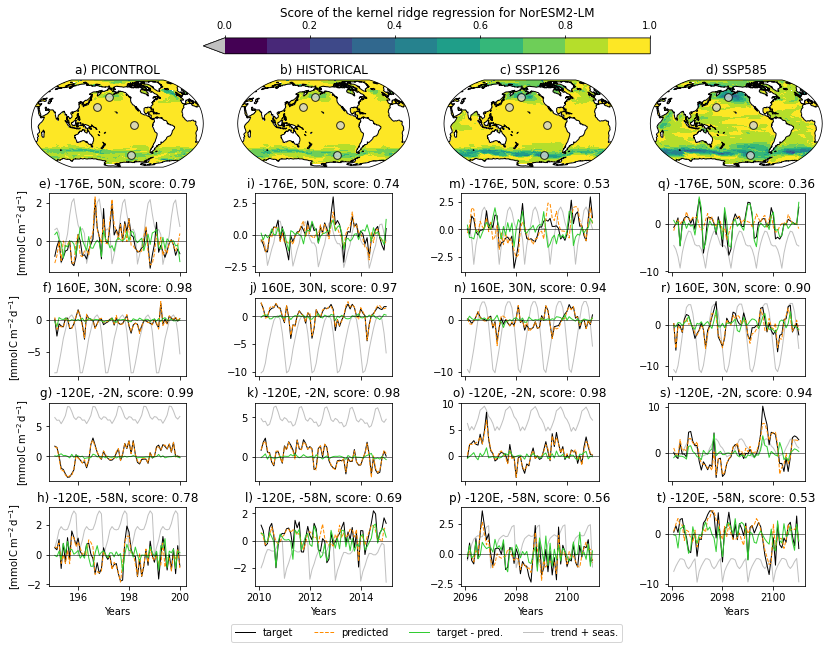

In [15]:
%%time
print(datetime.datetime.now())
print('About the low score in the southern ocean and SSP585\n'+\
      '-> Maps of score and 3 grid-points chosen: fig')

# Load data2plot
savedfile = dirout + 'data2plot-score-maps-and-timeseries.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)        

#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
nrow = 1
ncol = len(simu_list)
ccrsproj = ccrs.Robinson(central_longitude=-155)
fsize = (18*cm2in*2, 16*cm2in*2) # width height
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, 
                       subplot_kw=dict(projection=ccrsproj),
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#-----------------
# CREATE CUSTOM CMAP
#-----------------

cmap = cm.get_cmap('viridis', 256)
newcolors = cmap(np.linspace(0, 1, 10))
cmap = ListedColormap(newcolors[:])
cmap.set_under(color='silver')
cmap.set_over(color='silver')
cmap.set_bad(color='silver', alpha=0)

#-----------------
# KEYWORDS DICT
#-----------------

kwmap = {'vmin':0, 'vmax':1, 'cmap':cmap, \
         'transform':ccrs.PlateCarree() }
kwscatter = dict(edgecolor='k', facecolor='lightgray', alpha = .8, s=60, \
                 transform=ccrs.PlateCarree())
kwtrue = dict(lw=1, ls='-' , label='target'       , color='k'        )
kwpred = dict(lw=1, ls='--', label='predicted'  , color='darkorange')
kwdiff = dict(lw=1, ls='-' , label='target - pred.', color='limegreen')
kwtrnd = dict(lw=1, ls='-' , label='trend + seas.' , color='silver')

kwbbox = dict(boxstyle ="round", fc ="0.8")

#=====================
#=====================
# MAPS
#=====================
#=====================

irow = 0
icol = 0
for simu in simu_list: 
    zax = ax[irow, icol]
    X = data2plot[simu]['score']['X']
    Y = data2plot[simu]['score']['Y']
    Z = data2plot[simu]['score']['Z']
    pcm = zax.pcolormesh(X, Y, Z, **kwmap)   
    zax.set_title(subnum.pop() + ') ' + simu.upper())
    zax.coastlines()
    # gl = zax.gridlines(crs=ccrs.PlateCarree(), linewidth=1)
    for gridpt in gridpt_list: 
        jj, ii = gridpt[0], gridpt[1]
        zax.scatter(X[jj, ii], Y[jj, ii], **kwscatter)
    #
#

    icol+=1
#

#=====================
#=====================
# TIMESERIES
#=====================
#=====================

axts = [] 
for isimu, vsimu in enumerate(simu_list): 

    for igridpt, vgridpt in enumerate(gridpt_list): 
        
        #---------------
        # create axes
        #---------------

        zw1 = ax.flat[isimu].get_position()
        nx0 = zw1.x0+.1*zw1.width
        ny0 = zw1.y0 - (igridpt+1)*1.2*zw1.height
        nw  = .8*zw1.width
        nh  = .9*zw1.height
        zaxts = fig.add_axes([nx0, ny0, nw, nh]) 
        axts.append(zaxts)

        #---------------
        # Plot
        #---------------
        
        X = data2plot[vsimu]['timeseries '+str(igridpt)]['X']
        Y = data2plot[vsimu]['timeseries '+str(igridpt)]['trdseas']
        lltrnd, = zaxts.plot(X, Y, **kwtrnd)
        Y = data2plot[vsimu]['timeseries '+str(igridpt)]['true']
        lltrue, = zaxts.plot(X, Y, **kwtrue)
        Y = data2plot[vsimu]['timeseries '+str(igridpt)]['pred']
        llpred, = zaxts.plot(X, Y, **kwpred)
        Y = data2plot[vsimu]['timeseries '+str(igridpt)]['diff']
        lldiff, = zaxts.plot(X, Y, **kwdiff)
        zaxts.axhline(0, lw=.5, c='k')
        zwtxt = subnum.pop() + ') %.0fE, %.0fN' %data2plot[vsimu]['timeseries '+str(igridpt)]['coords'] + \
        ', score: %.2f' %data2plot[vsimu]['timeseries '+str(igridpt)]['score']
        zaxts.set_title(zwtxt) 
        if isimu == 0: zaxts.set_ylabel('[mmol$\,$C$\,$m$^{-2}\,$d$^{-1}$]')
    #
#
axts = np.array(axts).reshape((len(simu_list), len(gridpt_list))).T

#=====================
#=====================
# Decorate figure
#=====================
#=====================

#---------------------
# Colorbar
#---------------------

zw1 = ax[0, 0].get_position()
zw2 = ax[0, -1].get_position()
nx0 = zw1.x1
ny0 = zw1.y1 + .3*zw1.height
nw  = zw2.x0  - nx0
nh  = 0.04*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal', \
                    ticklocation='top', extend='min')
cbar.set_label('Score of the kernel ridge regression for '+model, size=12)

#---------------------
# Set time series labels
#---------------------

for zax in axts[0:-1, :].flat: 
    zax.set_xticklabels('')
#
for zax in axts[-1, :].flat: 
    zax.set_xlabel('Years')
#

#-----------------
# Legend
#-----------------

zw1 = axts[-1, 0].get_position()
zw2 = axts[-1, -1].get_position()
nx0 = (zw1.x0 + zw2.x1)/2.
ny0 = zw1.y0 - .6*zw1.height
nw  = 0
nh  = 0
legax = fig.add_axes([nx0, ny0, nw, nh])

hdls = [xxx for xxx in axts[0, 0].lines]
hdls = [lltrue, llpred, lldiff, lltrnd]
legax.legend(handles=hdls, ncol=len(hdls), loc='center')
legax.axis('off')

#---------------------
# Save figure
#---------------------

fignam = 'score-maps-and-timeseries.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# 23s

## Periodograms for historical

### Inputs

In [19]:
%%time
print(datetime.datetime.now())
print('About the low score in the southern ocean and SSP585\n'+\
      '-> Periodograms for historical: inputs')

# model_list = ['NorESM2-LM', 'MPI-ESM1-2-LR', 'CNRM-ESM2-1', 'CESM2', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR']
model = 'NorESM2-LM'
# simu_list  = ['picontrol', 'historical', 'ssp126', 'ssp585']
simu = 'historical'
pred_list = ['fgco2', 'dissic', 'talk', 'tos', 'sfcWind', 'sos', 'po4']
#grid_list  = ['90x45', '180x90']
grid  = '360x180'

# Create and add a Rectangle patch
gridpt_baselist = [(8, 15), (22, 15), (30, 85), (35, 1)]

if   grid == '90x45'   : gridpt_list = [(ii*1, jj*1) for (ii, jj) in gridpt_baselist]
elif grid == '180x90'  : gridpt_list = [(ii*2, jj*2) for (ii, jj) in gridpt_baselist]
elif grid == '360x180' : gridpt_list = [(ii*4, jj*4) for (ii, jj) in gridpt_baselist]
gridpt_list = gridpt_list[::-1]

# gridpt = (30, 85)


2023-06-29 13:33:37.844814
About the low score in the southern ocean and SSP585
-> Periodograms for historical: inputs
CPU times: user 64 µs, sys: 0 ns, total: 64 µs
Wall time: 72 µs


### Prepare and save data2plot

In [17]:
%%time
print(datetime.datetime.now())
print('About the low score in the southern ocean and SSP585\n'+\
      '-> Periodograms for historical: prepare and save data2plot')

data2plot = {}

#=====================
#=====================
#=====================
# Periodograms
#=====================
#=====================
#=====================

zfact = {
    'fgco2': 1e6*3600*24/12, # kgC/m2/s -> mmolC/m2/d
    'dissic': 1000., # mmol/m3
    'talk': 1000., # mmol/m3
    'po4': 1000., # mmol/m3
    'tos': 1., # degC    
    'sos': 1., # psu
    'sfcWind': 1., # m/s
}

for ipred, vpred in enumerate(pred_list):
    
    data2plot[vpred] = {}
    
    #---------------------
    # load datas
    #---------------------

    dirname = dircmip6 + model + '/' + simu + '/'
    fname = vpred + '_' + model + '_' + simu + '*.nc'
    zwds = xr.open_mfdataset(dirname + fname, use_cftime=True)
    print('File loaded: %s' %fname)
    zwda = zwds[vpred]*zfact[vpred]

    if vpred == 'fgco2': 
        savedfile = dirshared + 'cfx-true-pred-std-' + model+'-'+simu+'-'+grid+'.pckl'
        with open(savedfile, 'rb') as f1: zwdata = pickle.load(f1)
        print("File loaded: "+savedfile)            
        cfxtrue = zwdata['cfxtrue'].T
        cfxpred = zwdata['cfxpred'].T
    #
    
        
    #---------------------
    # loop on gridpt
    #---------------------

    for igridpt, vgridpt in enumerate(gridpt_list): 

        
        data2plot[vpred]['gridpt '+str(igridpt)] = {}
        
        #_______________
        # extract grid point
        jj, ii = vgridpt[0], vgridpt[1]
        zw = zwda.isel(lat=jj, lon=ii).values.squeeze()
        lon = zwda.isel(lat=jj, lon=ii).lon.values.squeeze()
        lat = zwda.isel(lat=jj, lon=ii).lat.values.squeeze()
        
        #_______________
        # Compute periodogram
        fs = 12 # monthly sample (12 per year)
        freq, Pxx_den = periodogram(zw, fs)

        #_______________
        # Save data
        data2plot[vpred]['gridpt '+str(igridpt)]['X'] = freq
        data2plot[vpred]['gridpt '+str(igridpt)]['Y'] = Pxx_den
        data2plot[vpred]['gridpt '+str(igridpt)]['coords'] = (lon, lat)   
        
        if vpred == 'fgco2': 
        
            #_______________
            # extract grid point
            zwtrue = cfxtrue[:, jj, ii].squeeze() * 1e6*3600*24
            zwpred = cfxpred[:, jj, ii].squeeze() * 1e6*3600*24

            #_______________
            # Compute periodogram
            fs = 12 # monthly sample (12 per year)
            freq_true, Pxx_den_true = periodogram(zwtrue, fs)
            freq_pred, Pxx_den_pred = periodogram(zwpred, fs)
            
            #_______________
            # Save data
            data2plot[vpred]['gridpt '+str(igridpt)]['true'] = {'X':freq_true, 'Y':Pxx_den_true}
            data2plot[vpred]['gridpt '+str(igridpt)]['pred'] = {'X':freq_pred, 'Y':Pxx_den_pred}
        #
    #
#

#=====================
#=====================
#=====================
# Score
#=====================
#=====================
#=====================

#---------------------
# load datas
#---------------------

savedfile = dirshared + 'score-std-' + model+'-'+simu+'-'+grid+'.pckl'
with open(savedfile, 'rb') as f1: zwdata = pickle.load(f1)
print("File loaded: "+savedfile)
score = zwdata['totscor_avg'].T

#---------------------
# loop on gridpt
#---------------------

data2plot['score'] = {}
for igridpt, vgridpt in enumerate(gridpt_list): 
    jj, ii = vgridpt[0], vgridpt[1]
    data2plot['score']['gridpt '+str(igridpt)] = score[jj, ii]
#

savedfile = dirout + 'data2plot-periodograms-historical.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("File saved: "+savedfile)        

# ca. 20s

2023-06-28 15:11:48.438777
About the low score in the southern ocean and SSP585
-> Periodograms for historical: prepare and save data2plot
File loaded: fgco2_NorESM2-LM_historical*.nc
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-NorESM2-LM-historical-360x180.pckl
File loaded: dissic_NorESM2-LM_historical*.nc
File loaded: talk_NorESM2-LM_historical*.nc
File loaded: tos_NorESM2-LM_historical*.nc
File loaded: sfcWind_NorESM2-LM_historical*.nc
File loaded: sos_NorESM2-LM_historical*.nc
File loaded: po4_NorESM2-LM_historical*.nc
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/score-std-NorESM2-LM-historical-360x180.pckl
File saved: dimred-230621-figure-article-review1-v0/data2plot-periodograms-historical.pckl
CPU times: user 11.5 s, sys: 3.28 s, total: 14.7 s
Wall time: 11.9 s


### Fig

2023-06-29 13:36:02.826335
About the low score in the southern ocean and SSP585
-> Periodograms for historical: fig
File loaded: dimred-230621-figure-article-review1-v0/data2plot-periodograms-historical.pckl
Figure saved: periodograms-historical.png
CPU times: user 2.89 s, sys: 774 ms, total: 3.67 s
Wall time: 2.85 s


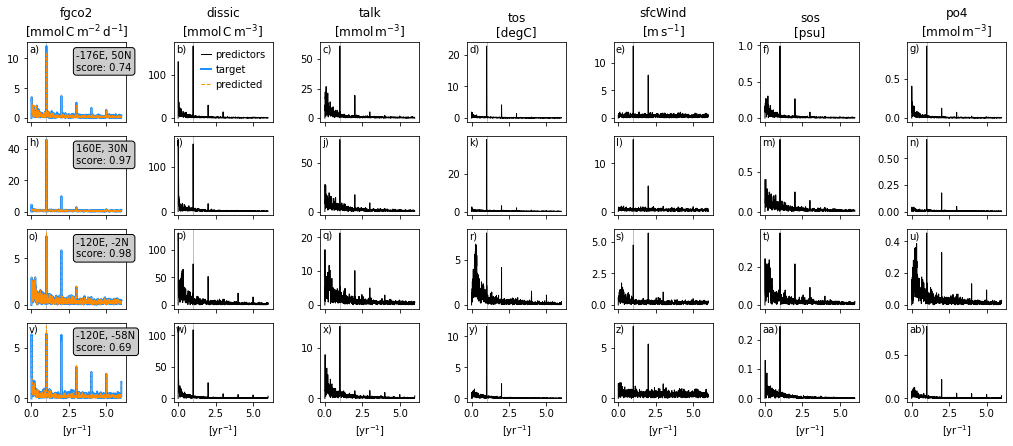

In [21]:
%%time
print(datetime.datetime.now())
print('About the low score in the southern ocean and SSP585\n'+\
      '-> Periodograms for historical: fig')

# Load data2plot
savedfile = dirout + 'data2plot-periodograms-historical.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)        


#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
fsize = (18*cm2in*2, 16*cm2in) # width height
ncol = len(pred_list)
nrow = len(gridpt_list)
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, squeeze=False, \
                      sharey=False, sharex=True)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()


units = {
    'fgco2': '[mmol$\,$C$\,$m$^{-2}\,$d$^{-1}$]',
    'dissic': '[mmol$\,$C$\,$m$^{-3}$]',
    'talk': '[mmol$\,$m$^{-3}$]',
    'po4': '[mmol$\,$m$^{-3}$]',
    'tos': '[degC]',    
    'sos': '[psu]',
    'sfcWind': '[m$\,$s$^{-1}$]'    
}

#-----------------
# KEYWORDS DICT
#-----------------

kwtarg = dict(lw=2, ls='-', label='target'      , color='dodgerblue')
kwbase = dict(lw=1, ls='-', label='predictors'  , color='black'        )
kwpred = dict(lw=1, ls='--', label='predicted'   , color='darkorange')

kwbbox = dict(boxstyle ="round", fc ="0.8")

#-----------------
# PLOT
#-----------------

for igridpt, vgridpt in enumerate(gridpt_list): 
    for ipred, vpred in enumerate(pred_list):
        
        zwdata = data2plot[vpred]['gridpt '+str(igridpt)]
        zax = ax[igridpt, ipred]
        zax.axvline(1., ls='-', c='silver', lw=1)
        if vpred=='fgco2': 
            X, Y = zwdata['X'], np.sqrt(zwdata['Y'])
            lltarg, = zax.plot(X, Y, **kwtarg)
            #lltarg, = zax.semilogx(X, Y, **kwtarg)
            # X, Y = zwdata['true']['X'], np.sqrt(zwdata['true']['Y'])
            # ll, = zax.plot(X, Y, **kwtrue)
            X, Y = zwdata['pred']['X'], np.sqrt(zwdata['pred']['Y'])
            llpred, = zax.plot(X, Y, **kwpred)
            #llpred, = zax.semilogx(X, Y, **kwpred)
        else: 
            X, Y = zwdata['X'], np.sqrt(zwdata['Y'])
            llbase, = zax.plot(X, Y, **kwbase)
            #llbase, = zax.semilogx(X, Y, **kwbase)
        #

        zax.annotate(subnum.pop()+')', (0.02, 0.88),xycoords='axes fraction')
        if igridpt==len(gridpt_list)-1: zax.set_xlabel('[yr$^{-1}$]')
        if ipred==0:
            zwtxt = '%.0fE, %.0fN' %zwdata['coords'] + \
            '\nscore: %.2f' %data2plot['score']['gridpt '+str(igridpt)]
            zax.annotate(zwtxt, (0.5, 0.65), xycoords='axes fraction', bbox=kwbbox) 
        #
        if igridpt==0: 
            zwtxt = vpred + '\n'+units[vpred]
            zax.set_title(zwtxt, loc='center')
        #

    #
#
        
fig.tight_layout()



#-----------------
# Legend
#-----------------

#ax[0, 1].legend(handles=[ax[0, 0].lines[0], ax[0, 0].lines[1], ax[0, 1].lines[0]], 
#                handlelength=1., handletextpad=.4, borderpad=.2, frameon=False)
ax[0, 1].legend(handles=[llbase, lltarg, llpred], 
                handlelength=1., handletextpad=.4, borderpad=.2, frameon=False)

#-----------------
# Save figure
#-----------------

fignam = 'periodograms-historical.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)
    
# ca. 3s

## Periodograms for historical, ssp126 and ssp585

### Inputs

In [46]:
%%time
print(datetime.datetime.now())
print('About the low score in the southern ocean and SSP585\n'+\
      '-> Periodograms for historical, ssp126, ssp585: inputs')

# model_list = ['NorESM2-LM', 'MPI-ESM1-2-LR', 'CNRM-ESM2-1', 'CESM2', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR']
model = 'NorESM2-LM'
simu_list  = ['historical', 'ssp126', 'ssp585']
#grid_list  = ['90x45', '180x90']
grid  = '360x180'

# Create and add a Rectangle patch
gridpt_baselist = [(8, 15), (22, 15), (30, 85), (35, 1)]

if   grid == '90x45'   : gridpt_list = [(ii*1, jj*1) for (ii, jj) in gridpt_baselist]
elif grid == '180x90'  : gridpt_list = [(ii*2, jj*2) for (ii, jj) in gridpt_baselist]
elif grid == '360x180' : gridpt_list = [(ii*4, jj*4) for (ii, jj) in gridpt_baselist]
gridpt_list = gridpt_list[::-1]

# gridpt = (30, 85)


2023-06-28 15:31:35.091638
About the low score in the southern ocean and SSP585
-> Periodograms for historical, ssp126, ssp585: inputs
CPU times: user 55 µs, sys: 11 µs, total: 66 µs
Wall time: 73.7 µs


### Prepare and save data2plot

In [47]:
%%time
print(datetime.datetime.now())
print('About the low score in the southern ocean and SSP585\n'+\
      '-> Periodograms for historical, ssp126, ssp585: prepare and save data2plot')

data2plot = {}

zfact = 1e6*3600*24, # kmolC/m2/s -> mmolC/m2/d

for isimu, vsimu in enumerate(simu_list):
    
    data2plot[vsimu] = {}
    
    #---------------------
    # load datas
    #---------------------


    savedfile = dirshared + 'cfx-true-pred-std-' + model+'-'+vsimu+'-'+grid+'.pckl'
    with open(savedfile, 'rb') as f1: zwdata = pickle.load(f1)
    print("File loaded: "+savedfile)            
    cfxtrue = zwdata['cfxtrue'].T * zfact
    cfxpred = zwdata['cfxpred'].T * zfact
    lon = zwdata['lon'].T
    lat = zwdata['lat'].T

    savedfile = dirshared + 'score-std-' + model+'-'+vsimu+'-'+grid+'.pckl'
    with open(savedfile, 'rb') as f1: zwdata = pickle.load(f1)
    print("File loaded: "+savedfile)
    score = zwdata['totscor_avg'].T

    #---------------------
    # loop on gridpt
    #---------------------

    for igridpt, vgridpt in enumerate(gridpt_list): 

        data2plot[vsimu]['gridpt '+str(igridpt)] = {}
        jj, ii = vgridpt[0], vgridpt[1]

        #_______________
        # extract grid point
        zwcfxtrue = cfxtrue[:, jj, ii].squeeze()
        zwcfxpred = cfxpred[:, jj, ii].squeeze()
                
        #_______________
        # detrend and deseasonalized        
        t = np.linspace(0, zwcfxtrue.shape[0] - 1, num=zwcfxtrue.shape[0])
        trdtrue = p_smooth_spline(t, zwcfxtrue)
        dtdstrue, trdseastrue, seastrue = dtrd_dseas(zwcfxtrue, trdtrue)
        trdpred = p_smooth_spline(t, zwcfxpred)
        dtdspred, trdseaspred, seaspred = dtrd_dseas(zwcfxpred, trdpred)
        dtdspred2 = zwcfxpred - trdseastrue
        
        #_______________
        # Compute periodogram
        fs = 12 # monthly sample (12 per year)
        # all signal
        freq_true, Pxx_den_true = periodogram(zwcfxtrue, fs)
        freq_pred, Pxx_den_pred = periodogram(zwcfxpred, fs)
        # trend
        freq_trdtrue, Pxx_den_trdtrue = periodogram(trdtrue, fs)
        freq_trdpred, Pxx_den_trdpred = periodogram(trdpred, fs)
        # seas
        freq_seastrue, Pxx_den_seastrue = periodogram(seastrue, fs)
        freq_seaspred, Pxx_den_seaspred = periodogram(seaspred, fs)
        # trdseas
        freq_trdseastrue, Pxx_den_trdseastrue = periodogram(trdseastrue, fs)
        freq_trdseaspred, Pxx_den_trdseaspred = periodogram(trdseaspred, fs)
        # dtds
        freq_dtdstrue, Pxx_den_dtdstrue = periodogram(dtdstrue, fs)
        freq_dtdspred, Pxx_den_dtdspred = periodogram(dtdspred, fs)
        freq_dtdspred2, Pxx_den_dtdspred2 = periodogram(dtdspred2, fs)
        # dt
        freq_dttrue, Pxx_den_dttrue = periodogram(zwcfxtrue - trdtrue, fs)
        freq_dtpred, Pxx_den_dtpred = periodogram(zwcfxpred - trdpred, fs)

        #_______________
        # Save data
        data2plot[vsimu]['gridpt '+str(igridpt)]['true'] = {'X':freq_true, 'Y':Pxx_den_true}
        data2plot[vsimu]['gridpt '+str(igridpt)]['pred'] = {'X':freq_pred, 'Y':Pxx_den_pred}
        data2plot[vsimu]['gridpt '+str(igridpt)]['trdtrue'] = {'X':freq_trdtrue, 'Y':Pxx_den_trdtrue}
        data2plot[vsimu]['gridpt '+str(igridpt)]['trdpred'] = {'X':freq_trdpred, 'Y':Pxx_den_trdpred}
        data2plot[vsimu]['gridpt '+str(igridpt)]['seastrue'] = {'X':freq_seastrue, 'Y':Pxx_den_seastrue}
        data2plot[vsimu]['gridpt '+str(igridpt)]['seaspred'] = {'X':freq_seaspred, 'Y':Pxx_den_seaspred}
        data2plot[vsimu]['gridpt '+str(igridpt)]['trdseastrue'] = {'X':freq_trdseastrue, 'Y':Pxx_den_trdseastrue}
        data2plot[vsimu]['gridpt '+str(igridpt)]['trdseaspred'] = {'X':freq_trdseaspred, 'Y':Pxx_den_trdseaspred}
        data2plot[vsimu]['gridpt '+str(igridpt)]['dtdstrue'] = {'X':freq_dtdstrue, 'Y':Pxx_den_dtdstrue}
        data2plot[vsimu]['gridpt '+str(igridpt)]['dtdspred'] = {'X':freq_dtdspred, 'Y':Pxx_den_dtdspred}
        data2plot[vsimu]['gridpt '+str(igridpt)]['dttrue'] = {'X':freq_dttrue, 'Y':Pxx_den_dttrue}
        data2plot[vsimu]['gridpt '+str(igridpt)]['dtpred'] = {'X':freq_dtpred, 'Y':Pxx_den_dtpred}
        data2plot[vsimu]['gridpt '+str(igridpt)]['dtdspred2'] = {'X':freq_dtdspred2, 'Y':Pxx_den_dtdspred2}
        data2plot[vsimu]['gridpt '+str(igridpt)]['score'] = score[jj, ii]
        data2plot[vsimu]['gridpt '+str(igridpt)]['coords'] = (lon[jj, ii], lat[jj, ii])   

    #

#
savedfile = dirout + 'data2plot-periodograms-historical-ssp126-ssp585.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("File saved: "+savedfile)        

# ca. 2s

2023-06-28 15:31:35.965839
About the low score in the southern ocean and SSP585
-> Periodograms for historical, ssp126, ssp585: prepare and save data2plot
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-NorESM2-LM-historical-360x180.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/score-std-NorESM2-LM-historical-360x180.pckl
smoothing factor:  4629.0359848245735
smoothing factor:  3939.3167454194795
smoothing factor:  30433.74777661758
smoothing factor:  30202.70560941273
smoothing factor:  5216.098012651931
smoothing factor:  5123.479878440348
smoothing factor:  3956.767153601349
smoothing factor:  3413.9284147329226
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-NorESM2-LM-ssp126-360x180.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/score-std-NorESM2-LM-ssp126-360x180.pckl
smoothing factor:  3632.715873580189
smoothing

### Fig

#### full

2023-06-28 15:33:53.670015
About the low score in the southern ocean and SSP585
-> Periodograms for historical, ssp126, ssp585: fig
File loaded: dimred-230621-figure-article-review1-v0/data2plot-periodograms-historical-ssp126-ssp585.pckl
Figure saved: periodograms-full-historical-ssp126-ssp585.png
CPU times: user 1.38 s, sys: 584 ms, total: 1.97 s
Wall time: 1.3 s


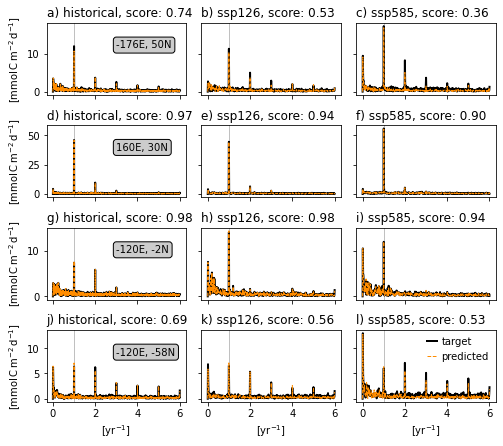

In [52]:
%%time
print(datetime.datetime.now())
print('About the low score in the southern ocean and SSP585\n'+\
      '-> Periodograms for historical, ssp126, ssp585: fig')

# Load data2plot
savedfile = dirout + 'data2plot-periodograms-historical-ssp126-ssp585.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)        


#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
fsize = (18*cm2in, 16*cm2in) # width height
ncol = len(simu_list)
nrow = len(gridpt_list)
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, squeeze=False, \
                      sharey='row', sharex=True)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()


units = '[mmol$\,$C$\,$m$^{-2}\,$d$^{-1}$]'
#-----------------
# KEYWORDS DICT
#-----------------

kwtrue = dict(lw=2, ls='-' , label='target'     , color='k'        )
kwpred = dict(lw=1, ls='--', label='predicted', color='darkorange')

kwbbox = dict(boxstyle ="round", fc ="0.8")

#-----------------
# PLOT
#-----------------

for igridpt, vgridpt in enumerate(gridpt_list): 
    for isimu, vsimu in enumerate(simu_list):
        
        zwdata = data2plot[vsimu]['gridpt '+str(igridpt)]
        zax = ax[igridpt, isimu]
        zax.axvline(1., ls='-', c='silver', lw=1)
        X, Y = zwdata['true']['X'], np.sqrt(zwdata['true']['Y'])
        ll, = zax.plot(X, Y, **kwtrue)
        X, Y = zwdata['pred']['X'], np.sqrt(zwdata['pred']['Y'])
        ll, = zax.plot(X, Y, **kwpred)

        zwtxt = subnum.pop() + ') '+vsimu + \
            ', score: %.2f' %zwdata['score']
        zax.set_title(zwtxt, loc='left') 
        if igridpt==len(gridpt_list)-1: zax.set_xlabel('[yr$^{-1}$]')
        if isimu==0:
            zax.set_ylabel(units)
            zwtxt = '%.0fE, %.0fN' %zwdata['coords'] 
            zax.annotate(zwtxt, (0.5, 0.65), xycoords='axes fraction', bbox=kwbbox) 
        #
    #
#
        
fig.tight_layout()

#-----------------
# Legend
#-----------------

zax.legend(handlelength=1., handletextpad=.4, borderpad=.2, frameon=False)

#-----------------
# Save figure
#-----------------

fignam = 'periodograms-full-historical-ssp126-ssp585.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)
    
# ca. 3s

#### DTDS

2023-06-28 15:34:53.448338
About the low score in the southern ocean and SSP585
-> Periodograms for historical, ssp126, ssp585: fig
File loaded: dimred-230621-figure-article-review1-v0/data2plot-periodograms-historical-ssp126-ssp585.pckl
Figure saved: periodograms-dtds-historical-ssp126-ssp585.png
CPU times: user 1.43 s, sys: 609 ms, total: 2.04 s
Wall time: 1.37 s


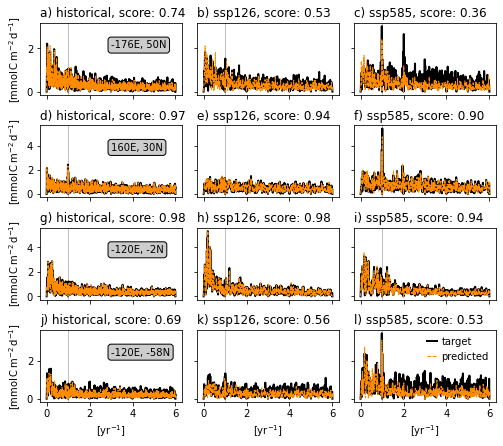

In [55]:
%%time
print(datetime.datetime.now())
print('About the low score in the southern ocean and SSP585\n'+\
      '-> Periodograms for historical, ssp126, ssp585: fig')

# Load data2plot
savedfile = dirout + 'data2plot-periodograms-historical-ssp126-ssp585.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)        


#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
fsize = (18*cm2in, 16*cm2in) # width height
ncol = len(simu_list)
nrow = len(gridpt_list)
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, squeeze=False, \
                      sharey='row', sharex=True)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()


units = '[mmol$\,$C$\,$m$^{-2}\,$d$^{-1}$]'
#-----------------
# KEYWORDS DICT
#-----------------

kwtrue = dict(lw=2, ls='-' , label='target'     , color='k'        )
kwpred = dict(lw=1, ls='--', label='predicted', color='darkorange')
kwpred2 = dict(lw=.5, ls=':', label='predicted2', color='dodgerblue')

kwbbox = dict(boxstyle ="round", fc ="0.8")

#-----------------
# PLOT
#-----------------

for igridpt, vgridpt in enumerate(gridpt_list): 
    for isimu, vsimu in enumerate(simu_list):
        
        zwdata = data2plot[vsimu]['gridpt '+str(igridpt)]
        zax = ax[igridpt, isimu]
        zax.axvline(1., ls='-', c='silver', lw=1)
        X, Y = zwdata['dtdstrue']['X'], np.sqrt(zwdata['dtdstrue']['Y'])
        ll, = zax.plot(X, Y, **kwtrue)
        X, Y = zwdata['dtdspred']['X'], np.sqrt(zwdata['dtdspred']['Y'])
        ll, = zax.plot(X, Y, **kwpred)
        # X, Y = zwdata['dtdspred2']['X'], np.sqrt(zwdata['dtdspred2']['Y'])
        # ll, = zax.plot(X, Y, **kwpred2)

        zwtxt = subnum.pop() + ') '+vsimu + \
            ', score: %.2f' %zwdata['score']
        zax.set_title(zwtxt, loc='left') 
        if igridpt==len(gridpt_list)-1: zax.set_xlabel('[yr$^{-1}$]')
        if isimu==0:
            zax.set_ylabel(units)
            zwtxt = '%.0fE, %.0fN' %zwdata['coords'] 
            zax.annotate(zwtxt, (0.5, 0.65), xycoords='axes fraction', bbox=kwbbox) 
        #
    #
#
        
fig.tight_layout()

#-----------------
# Legend
#-----------------

zax.legend(handlelength=1., handletextpad=.4, borderpad=.2, frameon=False)

#-----------------
# Save figure
#-----------------

fignam = 'periodograms-dtds-historical-ssp126-ssp585.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)
    
# ca. 3s

#### TRD

2023-06-28 15:35:17.011221
About the low score in the southern ocean and SSP585
-> Periodograms for historical, ssp126, ssp585: fig
File loaded: dimred-230621-figure-article-review1-v0/data2plot-periodograms-historical-ssp126-ssp585.pckl
Figure saved: periodograms-trd-historical-ssp126-ssp585.png
CPU times: user 1.69 s, sys: 619 ms, total: 2.31 s
Wall time: 1.64 s


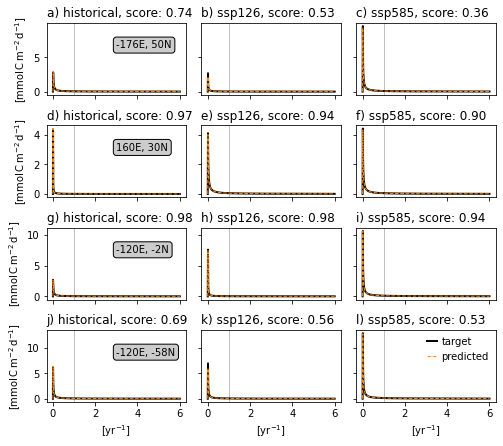

In [56]:
%%time
print(datetime.datetime.now())
print('About the low score in the southern ocean and SSP585\n'+\
      '-> Periodograms for historical, ssp126, ssp585: fig')

# Load data2plot
savedfile = dirout + 'data2plot-periodograms-historical-ssp126-ssp585.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)        


#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
fsize = (18*cm2in, 16*cm2in) # width height
ncol = len(simu_list)
nrow = len(gridpt_list)
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, squeeze=False, \
                      sharey='row', sharex=True)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()


units = '[mmol$\,$C$\,$m$^{-2}\,$d$^{-1}$]'
#-----------------
# KEYWORDS DICT
#-----------------

kwtrue = dict(lw=2, ls='-' , label='target'     , color='k'        )
kwpred = dict(lw=1, ls='--', label='predicted', color='darkorange')

kwbbox = dict(boxstyle ="round", fc ="0.8")

#-----------------
# PLOT
#-----------------

for igridpt, vgridpt in enumerate(gridpt_list): 
    for isimu, vsimu in enumerate(simu_list):
        
        zwdata = data2plot[vsimu]['gridpt '+str(igridpt)]
        zax = ax[igridpt, isimu]
        zax.axvline(1., ls='-', c='silver', lw=1)
        X, Y = zwdata['trdtrue']['X'], np.sqrt(zwdata['trdtrue']['Y'])
        ll, = zax.plot(X, Y, **kwtrue)
        X, Y = zwdata['trdpred']['X'], np.sqrt(zwdata['trdpred']['Y'])
        ll, = zax.plot(X, Y, **kwpred)

        zwtxt = subnum.pop() + ') '+vsimu + \
            ', score: %.2f' %zwdata['score']
        zax.set_title(zwtxt, loc='left') 
        if igridpt==len(gridpt_list)-1: zax.set_xlabel('[yr$^{-1}$]')
        if isimu==0:
            zax.set_ylabel(units)
            zwtxt = '%.0fE, %.0fN' %zwdata['coords'] 
            zax.annotate(zwtxt, (0.5, 0.65), xycoords='axes fraction', bbox=kwbbox) 
        #
    #
#
        
fig.tight_layout()

#-----------------
# Legend
#-----------------

zax.legend(handlelength=1., handletextpad=.4, borderpad=.2, frameon=False)

#-----------------
# Save figure
#-----------------

fignam = 'periodograms-trd-historical-ssp126-ssp585.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)
    
# ca. 3s

#### SEAS

2023-06-28 15:35:21.145565
About the low score in the southern ocean and SSP585
-> Periodograms for historical, ssp126, ssp585: fig
File loaded: dimred-230621-figure-article-review1-v0/data2plot-periodograms-historical-ssp126-ssp585.pckl
Figure saved: periodograms-seas-historical-ssp126-ssp585.png
CPU times: user 1.35 s, sys: 592 ms, total: 1.94 s
Wall time: 1.28 s


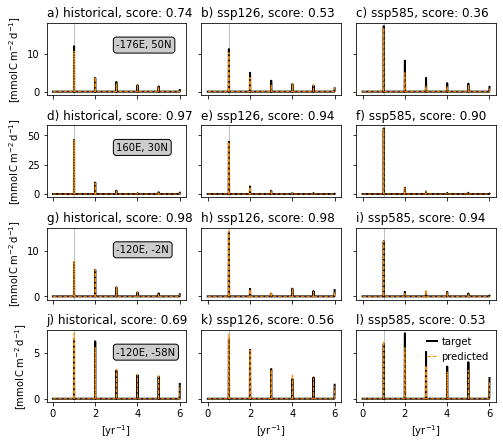

In [57]:
%%time
print(datetime.datetime.now())
print('About the low score in the southern ocean and SSP585\n'+\
      '-> Periodograms for historical, ssp126, ssp585: fig')

# Load data2plot
savedfile = dirout + 'data2plot-periodograms-historical-ssp126-ssp585.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)        


#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
fsize = (18*cm2in, 16*cm2in) # width height
ncol = len(simu_list)
nrow = len(gridpt_list)
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, squeeze=False, \
                      sharey='row', sharex=True)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()


units = '[mmol$\,$C$\,$m$^{-2}\,$d$^{-1}$]'
#-----------------
# KEYWORDS DICT
#-----------------

kwtrue = dict(lw=2, ls='-' , label='target'     , color='k'        )
kwpred = dict(lw=1, ls='--', label='predicted', color='darkorange')

kwbbox = dict(boxstyle ="round", fc ="0.8")

#-----------------
# PLOT
#-----------------

for igridpt, vgridpt in enumerate(gridpt_list): 
    for isimu, vsimu in enumerate(simu_list):
        
        zwdata = data2plot[vsimu]['gridpt '+str(igridpt)]
        zax = ax[igridpt, isimu]
        zax.axvline(1., ls='-', c='silver', lw=1)
        X, Y = zwdata['seastrue']['X'], np.sqrt(zwdata['seastrue']['Y'])
        ll, = zax.plot(X, Y, **kwtrue)
        X, Y = zwdata['seaspred']['X'], np.sqrt(zwdata['seaspred']['Y'])
        ll, = zax.plot(X, Y, **kwpred)

        zwtxt = subnum.pop() + ') '+vsimu + \
            ', score: %.2f' %zwdata['score']
        zax.set_title(zwtxt, loc='left') 
        if igridpt==len(gridpt_list)-1: zax.set_xlabel('[yr$^{-1}$]')
        if isimu==0:
            zax.set_ylabel(units)
            zwtxt = '%.0fE, %.0fN' %zwdata['coords'] 
            zax.annotate(zwtxt, (0.5, 0.65), xycoords='axes fraction', bbox=kwbbox) 
        #
    #
#
        
fig.tight_layout()

#-----------------
# Legend
#-----------------

zax.legend(handlelength=1., handletextpad=.4, borderpad=.2, frameon=False)

#-----------------
# Save figure
#-----------------

fignam = 'periodograms-seas-historical-ssp126-ssp585.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)
    
# ca. 3s

#### TRDSEAS

2023-06-28 15:35:24.049493
About the low score in the southern ocean and SSP585
-> Periodograms for historical, ssp126, ssp585: fig
File loaded: dimred-230621-figure-article-review1-v0/data2plot-periodograms-historical-ssp126-ssp585.pckl
Figure saved: periodograms-trdseas-historical-ssp126-ssp585.png
CPU times: user 1.32 s, sys: 601 ms, total: 1.93 s
Wall time: 1.26 s


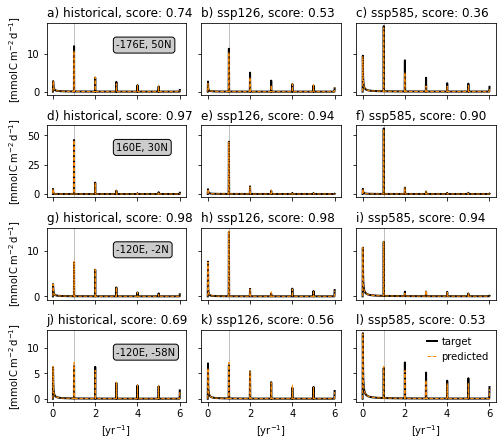

In [58]:
%%time
print(datetime.datetime.now())
print('About the low score in the southern ocean and SSP585\n'+\
      '-> Periodograms for historical, ssp126, ssp585: fig')

# Load data2plot
savedfile = dirout + 'data2plot-periodograms-historical-ssp126-ssp585.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)        


#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
fsize = (18*cm2in, 16*cm2in) # width height
ncol = len(simu_list)
nrow = len(gridpt_list)
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, squeeze=False, \
                      sharey='row', sharex=True)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()


units = '[mmol$\,$C$\,$m$^{-2}\,$d$^{-1}$]'
#-----------------
# KEYWORDS DICT
#-----------------

kwtrue = dict(lw=2, ls='-' , label='target'     , color='k'        )
kwpred = dict(lw=1, ls='--', label='predicted', color='darkorange')

kwbbox = dict(boxstyle ="round", fc ="0.8")

#-----------------
# PLOT
#-----------------

for igridpt, vgridpt in enumerate(gridpt_list): 
    for isimu, vsimu in enumerate(simu_list):
        
        zwdata = data2plot[vsimu]['gridpt '+str(igridpt)]
        zax = ax[igridpt, isimu]
        zax.axvline(1., ls='-', c='silver', lw=1)
        X, Y = zwdata['trdseastrue']['X'], np.sqrt(zwdata['trdseastrue']['Y'])
        ll, = zax.plot(X, Y, **kwtrue)
        X, Y = zwdata['trdseaspred']['X'], np.sqrt(zwdata['trdseaspred']['Y'])
        ll, = zax.plot(X, Y, **kwpred)

        zwtxt = subnum.pop() + ') '+vsimu + \
            ', score: %.2f' %zwdata['score']
        zax.set_title(zwtxt, loc='left') 
        if igridpt==len(gridpt_list)-1: zax.set_xlabel('[yr$^{-1}$]')
        if isimu==0:
            zax.set_ylabel(units)
            zwtxt = '%.0fE, %.0fN' %zwdata['coords'] 
            zax.annotate(zwtxt, (0.5, 0.65), xycoords='axes fraction', bbox=kwbbox) 
        #
    #
#
        
fig.tight_layout()

#-----------------
# Legend
#-----------------

zax.legend(handlelength=1., handletextpad=.4, borderpad=.2, frameon=False)

#-----------------
# Save figure
#-----------------

fignam = 'periodograms-trdseas-historical-ssp126-ssp585.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)
    
# ca. 3s

#### DT

2023-06-28 15:35:30.130347
About the low score in the southern ocean and SSP585
-> Periodograms for historical, ssp126, ssp585: fig
File loaded: dimred-230621-figure-article-review1-v0/data2plot-periodograms-historical-ssp126-ssp585.pckl
Figure saved: periodograms-dt-historical-ssp126-ssp585.png
CPU times: user 1.41 s, sys: 591 ms, total: 2 s
Wall time: 1.33 s


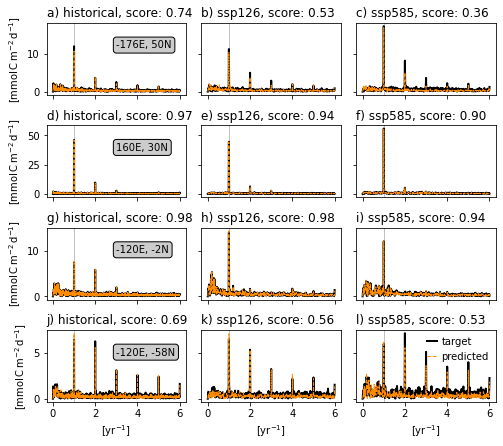

In [59]:
%%time
print(datetime.datetime.now())
print('About the low score in the southern ocean and SSP585\n'+\
      '-> Periodograms for historical, ssp126, ssp585: fig')

# Load data2plot
savedfile = dirout + 'data2plot-periodograms-historical-ssp126-ssp585.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)        


#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
fsize = (18*cm2in, 16*cm2in) # width height
ncol = len(simu_list)
nrow = len(gridpt_list)
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, squeeze=False, \
                      sharey='row', sharex=True)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()


units = '[mmol$\,$C$\,$m$^{-2}\,$d$^{-1}$]'
#-----------------
# KEYWORDS DICT
#-----------------

kwtrue = dict(lw=2, ls='-' , label='target'     , color='k'        )
kwpred = dict(lw=1, ls='--', label='predicted', color='darkorange')
kwpred2 = dict(lw=.5, ls=':', label='predicted2', color='dodgerblue')

kwbbox = dict(boxstyle ="round", fc ="0.8")

#-----------------
# PLOT
#-----------------

for igridpt, vgridpt in enumerate(gridpt_list): 
    for isimu, vsimu in enumerate(simu_list):
        
        zwdata = data2plot[vsimu]['gridpt '+str(igridpt)]
        zax = ax[igridpt, isimu]
        zax.axvline(1., ls='-', c='silver', lw=1)
        X, Y = zwdata['dttrue']['X'], np.sqrt(zwdata['dttrue']['Y'])
        ll, = zax.plot(X, Y, **kwtrue)
        X, Y = zwdata['dtpred']['X'], np.sqrt(zwdata['dtpred']['Y'])
        ll, = zax.plot(X, Y, **kwpred)
        # X, Y = zwdata['dtdspred2']['X'], np.sqrt(zwdata['dtdspred2']['Y'])
        # ll, = zax.plot(X, Y, **kwpred2)

        zwtxt = subnum.pop() + ') '+vsimu + \
            ', score: %.2f' %zwdata['score']
        zax.set_title(zwtxt, loc='left') 
        if igridpt==len(gridpt_list)-1: zax.set_xlabel('[yr$^{-1}$]')
        if isimu==0:
            zax.set_ylabel(units)
            zwtxt = '%.0fE, %.0fN' %zwdata['coords'] 
            zax.annotate(zwtxt, (0.5, 0.65), xycoords='axes fraction', bbox=kwbbox) 
        #
    #
#
        
fig.tight_layout()

#-----------------
# Legend
#-----------------

zax.legend(handlelength=1., handletextpad=.4, borderpad=.2, frameon=False)

#-----------------
# Save figure
#-----------------

fignam = 'periodograms-dt-historical-ssp126-ssp585.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)
    
# ca. 3s

## Periodograms for historical daily

### Inputs

In [31]:
%%time
print(datetime.datetime.now())
print('About the low score in the southern ocean and SSP585\n'+\
      '-> Periodograms for historical daily: inputs')

dname = '/mnt/reef-ns1002k-ns2345k/noresm/cases/NHISTfrc2_f19_tn14_noresm-dev_RECOUPLING/ocn/hist/'
fname = 'NHISTfrc2_f19_tn14_noresm-dev_RECOUPLING.micom.hbgcd.*'
fname2 = 'NHISTfrc2_f19_tn14_noresm-dev_RECOUPLING.micom.hd.*'

gridpt_list = [(292, 293), (265, 270), (179, 350), (69, 350)] # (jj, ii)


2023-06-29 13:44:37.856157
About the low score in the southern ocean and SSP585
-> Periodograms for historical daily: inputs
CPU times: user 60 µs, sys: 2 µs, total: 62 µs
Wall time: 67.2 µs


### Prepare and save data2plot

In [ ]:
%%time
print(datetime.datetime.now())
print('About the low score in the southern ocean and SSP585\n'+\
      '-> Periodograms for historical daily: prepare and save data2plot')

data2plot = {}


zfact = {
    'co2fxd': 1e6*3600*24/12, # kgC/m2/s -> mmolC/m2/d
    'co2fxu': 1e6*3600*24/12, # kgC/m2/s -> mmolC/m2/d
    'srfdissic': 1000., # mmol/m3
    'srftalk': 1000., # mmol/m3
    'sst': 1., # °C
    'sss': 1., # psu
}


#---------------------
# load datas
#---------------------

gridnoresm = xr.open_dataset('/mnt/reef-ns1002k/daco/grid_tnx1v4.nc')
lat = gridnoresm['plat']
lon = gridnoresm['plon']
zwds = xr.open_mfdataset(dname + fname, use_cftime=True)
print('File loaded: %s' %fname)
zwds2 = xr.open_mfdataset(dname + fname2, use_cftime=True)
print('File loaded: %s' %fname2)

for igridpt, vgridpt in enumerate(gridpt_list): 

    data2plot['gridpt '+str(igridpt)] = {}
    
    #_______________
    # extract grid point
    jj, ii = vgridpt[0], vgridpt[1]
    zwco2fxd = zwds['co2fxd'].isel(y=jj, x=ii) * zfact['co2fxd']
    zwco2fxu = zwds['co2fxu'].isel(y=jj, x=ii) * zfact['co2fxu']
    zwdic = zwds['srfdissic'].isel(y=jj, x=ii) * zfact['srfdissic']
    zwalk = zwds['srftalk'].isel(y=jj, x=ii)   * zfact['srftalk']
    
    zwsss = zwds2['sss'].isel(y=jj, x=ii) * zfact['sss']
    zwsst = zwds2['sst'].isel(y=jj, x=ii)   * zfact['sst']

    zwcfx = zwco2fxd - zwco2fxu
    
    #_______________
    # Compute periodogram
    fs = 365 # daily sample (365 per year)
    freq_cfx, Pxx_den_cfx = periodogram(zwcfx.values.squeeze(), fs)
    freq_dic, Pxx_den_dic = periodogram(zwdic.values.squeeze(), fs)
    freq_alk, Pxx_den_alk = periodogram(zwalk.values.squeeze(), fs)
    freq_sst, Pxx_den_sst = periodogram(zwsst.values.squeeze(), fs)
    freq_sss, Pxx_den_sss = periodogram(zwsss.values.squeeze(), fs)
    
    #_______________
    # Compute monthly average
    zwcfxM = zwcfx.resample(time="1M").mean()
    zwdicM = zwdic.resample(time="1M").mean()
    zwalkM = zwalk.resample(time="1M").mean()
    zwsstM = zwsst.resample(time="1M").mean()
    zwsssM = zwsss.resample(time="1M").mean()
    
    #_______________
    # Compute periodogram
    fs = 12 # monthly sample (12 per year)
    freq_cfxM, Pxx_den_cfxM = periodogram(zwcfxM.values.squeeze(), fs)
    freq_dicM, Pxx_den_dicM = periodogram(zwdicM.values.squeeze(), fs)
    freq_alkM, Pxx_den_alkM = periodogram(zwalkM.values.squeeze(), fs)
    freq_sstM, Pxx_den_sstM = periodogram(zwsstM.values.squeeze(), fs)
    freq_sssM, Pxx_den_sssM = periodogram(zwsssM.values.squeeze(), fs)

    
    #_______________
    # Save data
    data2plot['gridpt '+str(igridpt)]['coords'] = (lon[jj, ii], lat[jj, ii])   
    data2plot['gridpt '+str(igridpt)]['fgco2'] = {'X': freq_cfx, 'Y': Pxx_den_cfx}
    data2plot['gridpt '+str(igridpt)]['dissic'] = {'X': freq_dic, 'Y': Pxx_den_dic}
    data2plot['gridpt '+str(igridpt)]['talk'] = {'X': freq_alk, 'Y': Pxx_den_alk}
    data2plot['gridpt '+str(igridpt)]['sst'] = {'X': freq_sst, 'Y': Pxx_den_sst}
    data2plot['gridpt '+str(igridpt)]['sss'] = {'X': freq_sss, 'Y': Pxx_den_sss}
    data2plot['gridpt '+str(igridpt)]['fgco2M'] = {'X': freq_cfxM, 'Y': Pxx_den_cfxM}
    data2plot['gridpt '+str(igridpt)]['dissicM'] = {'X': freq_dicM, 'Y': Pxx_den_dicM}
    data2plot['gridpt '+str(igridpt)]['talkM'] = {'X': freq_alkM, 'Y': Pxx_den_alkM}
    data2plot['gridpt '+str(igridpt)]['sstM'] = {'X': freq_sstM, 'Y': Pxx_den_sstM}
    data2plot['gridpt '+str(igridpt)]['sssM'] = {'X': freq_sssM, 'Y': Pxx_den_sssM}

#

savedfile = dirout + 'data2plot-periodograms-historical-daily.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("File saved: "+savedfile)        

# ca. 50min

2023-06-28 18:53:53.940211
About the low score in the southern ocean and SSP585
-> Periodograms for historical daily: prepare and save data2plot
File loaded: NHISTfrc2_f19_tn14_noresm-dev_RECOUPLING.micom.hbgcd.*
File loaded: NHISTfrc2_f19_tn14_noresm-dev_RECOUPLING.micom.hd.*


### Fig

2023-06-29 13:53:10.914136
About the low score in the southern ocean and SSP585
-> Periodograms for historical daily: fig
File loaded: dimred-230621-figure-article-review1-v0/data2plot-periodograms-historical-daily.pckl
Figure saved: periodograms-historical-daily.png
CPU times: user 2.36 s, sys: 680 ms, total: 3.04 s
Wall time: 2.31 s


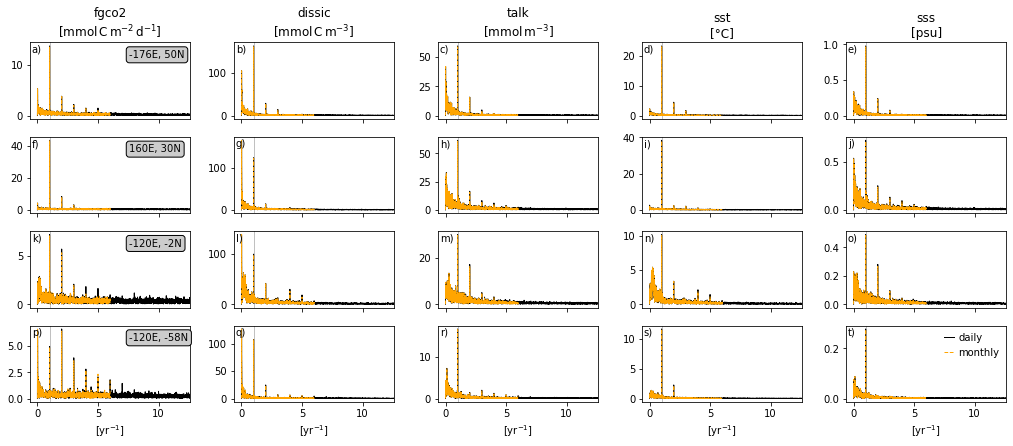

In [51]:
%%time
print(datetime.datetime.now())
print('About the low score in the southern ocean and SSP585\n'+\
      '-> Periodograms for historical daily: fig')

# Load data2plot
savedfile = dirout + 'data2plot-periodograms-historical-daily.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)        


#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
fsize = (18*cm2in*2, 16*cm2in) # width height
ncol = 5
nrow = len(gridpt_list)
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, squeeze=False, \
                      sharey=False, sharex=True)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()


units = {
    'fgco2' : '[mmol$\,$C$\,$m$^{-2}\,$d$^{-1}$]',
    'dissic': '[mmol$\,$C$\,$m$^{-3}$]',
    'talk'  : '[mmol$\,$m$^{-3}$]',
    'sst': '[°C]',
    'sss'  : '[psu]',
}

#-----------------
# KEYWORDS DICT
#-----------------

kwbase = dict(lw=1, label='daily', ls='-', color='k')
kwmon  = dict(lw=1, label='monthly', ls='--' , color='orange'        )

kwbbox = dict(boxstyle ="round", fc ="0.8")

#-----------------
# PLOT
#-----------------

for igridpt, vgridpt in enumerate(gridpt_list): 
    for ipred, vpred in enumerate(['fgco2', 'dissic', 'talk', 'sst', 'sss']):

        zax = ax[igridpt, ipred]
        zax.axvline(1., ls='-', c='silver', lw=1)
        
        zwdata = data2plot['gridpt '+str(igridpt)][vpred]
        X, Y = zwdata['X'], np.sqrt(zwdata['Y'])
        ll, = zax.plot(X, Y, **kwbase)
        #ll, = zax.semilogx(X, Y, **kwbase)
        zwdata = data2plot['gridpt '+str(igridpt)][vpred+'M']
        X, Y = zwdata['X'], np.sqrt(zwdata['Y'])
        ll, = zax.plot(X, Y, **kwmon)
        #ll, = zax.semilogx(X, Y, **kwmon)

        zax.annotate(subnum.pop()+')', (0.01, 0.87),xycoords='axes fraction')
        #__________
        # set xlim
        dmin, dmax = 0, 12
        xpad = 0.05*(dmax - dmin)
        zax.set_xlim((dmin-xpad, dmax+xpad))
        if igridpt==len(gridpt_list)-1: zax.set_xlabel('[yr$^{-1}$]')
        if ipred==0:
            zwtxt = '%.0fE, %.0fN' %data2plot['gridpt '+str(igridpt)]['coords']
            zax.annotate(zwtxt, (0.62, 0.8), xycoords='axes fraction', bbox=kwbbox) 
        #
        if igridpt==0: 
            zwtxt = vpred + '\n'+units[vpred]
            zax.set_title(zwtxt, loc='center')
        #

    #
#
        
fig.tight_layout()

#-----------------
# Legend
#-----------------

zax.legend(handlelength=1., handletextpad=.4, borderpad=.2, frameon=False)

#-----------------
# Save figure
#-----------------

fignam = 'periodograms-historical-daily.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)
    
# ca. 3s

## Periodograms for historical daily V2

### Inputs

In [52]:
%%time
print(datetime.datetime.now())
print('About the low score in the southern ocean and SSP585\n'+\
      '-> Periodograms for historical daily V2: inputs')

dname = '/mnt/reef-ns1002k/daco/DATA_CMIP6_DAILY/'

pred_list = ['tos', 'sos', 'sfcWind']
gridpt_list = {
    'tos': [(292, 293), (265, 270), (179, 350), (69, 350)], # (jj, ii) 
    'sos': [(292, 293), (265, 270), (179, 350), (69, 350)], # (jj, ii)
    'sfcWind': [(74, 74), (63, 64), (46, 96), (17, 96)] # (jj, ii)
}

zfact = {
    'sfcWind': 1., # m/s
    'tos': 1., # °C
    'sos': 1., # psu
}



2023-06-29 13:53:46.028282
About the low score in the southern ocean and SSP585
-> Periodograms for historical daily V2: inputs
CPU times: user 262 µs, sys: 12 µs, total: 274 µs
Wall time: 256 µs


### Prepare and save data2plot

In [7]:
%%time
print(datetime.datetime.now())
print('About the low score in the southern ocean and SSP585\n'+\
      '-> Periodograms for historical daily V2: prepare and save data2plot')

data2plot = {}

for ipred, vpred in enumerate(pred_list): 

    data2plot[vpred] = {}
    #_______________
    # load data
    zwfname = vpred+'*NorESM2-LM_historical_r1i1p1f1_gn*.nc'
    zwds = xr.open_mfdataset(dname+zwfname, use_cftime=True)
    zwda = zwds[vpred] * zfact[vpred]
    
    for igridpt, vgridpt in enumerate(gridpt_list[vpred]): 

        #_______________
        # extract grid point
        jj, ii = vgridpt[0], vgridpt[1]
        if vpred in ['sos', 'tos']: 
            zwpred = zwda.isel(j=jj, i=ii)
            lat = float(zwpred.latitude)
            lon = float(zwpred.longitude-360)
        elif vpred == 'sfcWind': 
            zwpred = zwda.isel(lat=jj, lon=ii)
            lat = float(zwpred.lat)
            lon = float(zwpred.lon-360)

        #_______________
        # Compute periodogram
        fs = 365 # daily sample (365 per year)
        freq_pred, Pxx_den_pred = periodogram(zwpred.values.squeeze(), fs)

        #_______________
        # Compute monthly average
        zwpredM = zwpred.resample(time="1M").mean()

        #_______________
        # Compute periodogram
        fs = 12 # monthly sample (12 per year)
        freq_predM, Pxx_den_predM = periodogram(zwpredM.values.squeeze(), fs)

        #_______________
        # Save data
        data2plot[vpred]['gridpt '+str(igridpt)] = {
            'coords' : (lon, lat),   
            'daily'  : {'X': freq_pred, 'Y': Pxx_den_pred},
            'monthly': {'X': freq_predM, 'Y': Pxx_den_predM}
        }
        

#

savedfile = dirout + 'data2plot-periodograms-historical-daily-v2.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("File saved: "+savedfile)        

# ca. 20s

2023-06-28 18:50:56.730448
About the low score in the southern ocean and SSP585
-> Periodograms for historical daily V2: prepare and save data2plot


KeyboardInterrupt: 

### Fig

2023-06-29 13:53:49.988691
About the low score in the southern ocean and SSP585
-> Periodograms for historical daily V2: fig
File loaded: dimred-230621-figure-article-review1-v0/data2plot-periodograms-historical-daily-v2.pckl
Figure saved: periodograms-historical-daily-v2.png
CPU times: user 1.58 s, sys: 567 ms, total: 2.15 s
Wall time: 1.5 s


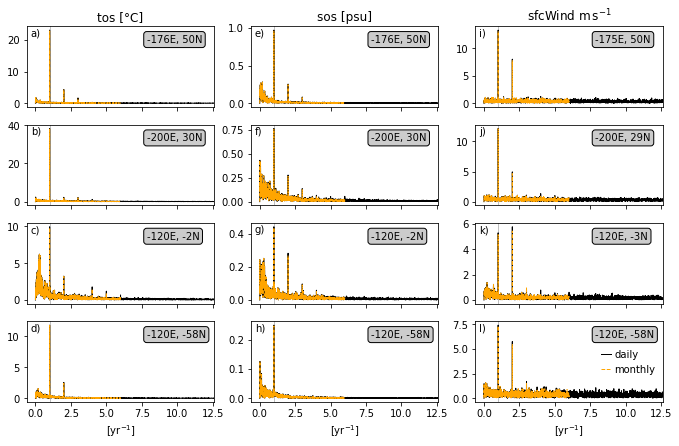

In [53]:
%%time
print(datetime.datetime.now())
print('About the low score in the southern ocean and SSP585\n'+\
      '-> Periodograms for historical daily V2: fig')

# Load data2plot
savedfile = dirout + 'data2plot-periodograms-historical-daily-v2.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)        


#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
fsize = (12*cm2in*2, 16*cm2in) # width height
ncol = len(pred_list)
nrow = len(gridpt_list[pred_list[0]])
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, squeeze=False, \
                      sharey=False, sharex=True)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()


units = {
    'sfcWind'  : 'm$\,$s$^{-1}$',
    'tos': '[°C]',
    'sos'  : '[psu]',
}

#-----------------
# KEYWORDS DICT
#-----------------

kwbase = dict(lw=1, label='daily', ls='-', color='k')
kwmon  = dict(lw=1, label='monthly', ls='--' , color='orange'        )

kwbbox = dict(boxstyle ="round", fc ="0.8")

#-----------------
# PLOT
#-----------------

for ipred, vpred in enumerate(pred_list):
    for igridpt, vgridpt in enumerate(gridpt_list[vpred]): 

        zax = ax[igridpt, ipred]
        zax.axvline(1., ls='-', c='silver', lw=1)
        
        zwdata = data2plot[vpred]['gridpt '+str(igridpt)]
        X, Y = zwdata['daily']['X'], np.sqrt(zwdata['daily']['Y'])
        ll, = zax.plot(X, Y, **kwbase)
        X, Y = zwdata['monthly']['X'], np.sqrt(zwdata['monthly']['Y'])
        ll, = zax.plot(X, Y, **kwmon)

        zax.annotate(subnum.pop()+')', (0.02, 0.88),xycoords='axes fraction')
        #__________
        # set xlim
        dmin, dmax = 0, 12
        xpad = 0.05*(dmax - dmin)
        zax.set_xlim((dmin-xpad, dmax+xpad))
        if igridpt==nrow-1: zax.set_xlabel('[yr$^{-1}$]')
        zwtxt = '%.0fE, %.0fN' %zwdata['coords']
        zax.annotate(zwtxt, (0.64, 0.8), xycoords='axes fraction', bbox=kwbbox) 
        #
        if igridpt==0: 
            zwtxt = vpred + ' '+units[vpred]
            zax.set_title(zwtxt, loc='center')
        #

    #
#
        
fig.tight_layout()

#-----------------
# Legend
#-----------------

zax.legend(handlelength=1., handletextpad=.4, borderpad=.2, frameon=False, loc='right')

#-----------------
# Save figure
#-----------------

fignam = 'periodograms-historical-daily-v2.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)
    
# ca. 3s

# About the detrending and deseasonalization

2023-06-22 16:39:29.331340
About the detrending and deseasonalization
CPU times: user 453 ms, sys: 313 ms, total: 767 ms
Wall time: 420 ms


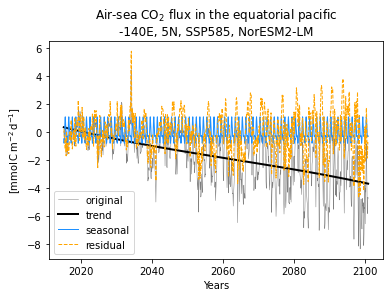

In [82]:
%%time
print(datetime.datetime.now())
print('About the detrending and deseasonalization')

dname = '/mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/from_klaus_timeseries_NorESM2-LM-ssp585/'
fname_dict = {
    'dtre': 'detrended.txt',
    'orig': 'original.txt',
    'seas': 'seasonal.txt',
    'tren': 'trend.txt',
    'dsea': 'deseasonalized.txt'
}
kwlines = {
    'orig': dict(color='gray'     , lw=.5, ls='-' , label='original'),
    'tren': dict(color='black'    , lw=2 , ls='-' , label='trend'),
    'dtre': dict(color='silver'    , lw=.5, ls='-' , label=''),
    'seas': dict(color='dodgerblue', lw=1 , ls='-' , label='seasonal'),
    'dsea': dict(color='orange'    , lw=1 , ls='--', label='residual')    
}

zfact = 1e6*3600*24, # kmolC/m2/s -> mmolC/m2/d

for kkk in ['orig', 'tren', 'seas', 'dsea']: 
    
    data = np.loadtxt(dname+fname_dict[kkk])*zfact
    X = np.arange(1, len(data)+1)/12.+2015
    plt.plot(X, data, **kwlines[kkk])
#
units = '[mmol$\,$C$\,$m$^{-2}\,$d$^{-1}$]'
plt.ylabel(units)
plt.xlabel('Years')
plt.title('Air-sea CO$_2$ flux in the equatorial pacific\n-140E, 5N, SSP585, NorESM2-LM', loc='center')
plt.legend()
fignam = 'about-detrending-deseasonalization.png'
plt.savefig(dirout+fignam, bbox_inches='tight')



# Maps of the reconstructed and target CO2 flux in NorESM2-LM historical

### Inputs

In [67]:
%%time
print(datetime.datetime.now())
print('Maps of the reconstructed and target CO2 flux in NorESM2-LM historical: inputs')

# model_list = ['NorESM2-LM', 'MPI-ESM1-2-LR', 'CNRM-ESM2-1', 'CESM2', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR']
vmodel = 'NorESM2-LM'
#simu_list  = ['picontrol', 'historical', 'ssp126', 'ssp585']
vsimu = 'historical'
#grid_list  = ['90x45', '180x90']
grid  = '360x180'

###############
###############
###############
zfact = 1e6*3600*24 # kmol/m2/s -> mmol/m2/d
###############
###############
###############


2023-06-26 18:50:52.545964
Maps of the reconstructed and target CO2 flux in NorESM2-LM historical: inputs
CPU times: user 0 ns, sys: 63 µs, total: 63 µs
Wall time: 71.5 µs


### Prepare and save data2plot

In [74]:
%%time
print(datetime.datetime.now())
print('Maps of the reconstructed and target CO2 flux in NorESM2-LM historical: prepare and save data2plot')

#_______________
# Load datas
savedfile = dirshared + 'cfx-true-pred-std-'+vmodel+'-'+vsimu+'-'+grid+'.pckl'
with open(savedfile, 'rb') as f1: zwdata = pickle.load(f1)
print("File loaded: "+savedfile)            

zwtrue = zwdata['cfxtrue'].T * zfact
zwpred = zwdata['cfxpred'].T * zfact        
lon = zwdata['lon'].T
lat = zwdata['lat'].T
        
#_______________
# Compute mean
cfxtrue = zwtrue.mean(axis=0)
cfxpred = zwpred.mean(axis=0)

#_______________
# Save data
data2plot = {
    'X': lon,
    'Y': lat,
    'true': cfxtrue,
    'pred': cfxpred
}


savedfile = dirout + 'data2plot-maps-reconstructed-targeted-co2flux-noresm2-lm-historical.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("File saved: "+savedfile)        

# ca. 1s

2023-06-26 18:54:29.513335
Maps of the reconstructed and target CO2 flux in NorESM2-LM historical: prepare and save data2plot
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-NorESM2-LM-historical-360x180.pckl
File saved: dimred-230621-figure-article-review1-v0/data2plot-maps-reconstructed-targeted-co2flux-noresm2-lm-historical.pckl
CPU times: user 193 ms, sys: 651 ms, total: 844 ms
Wall time: 913 ms


### Fig

2023-06-26 18:57:34.424579
NorESM2-LM historical reconstructed and targeted CO2 flux: fig
File loaded: dimred-230621-figure-article-review1-v0/data2plot-maps-reconstructed-targeted-co2flux-noresm2-lm-historical.pckl
Figure saved: maps-reconstructed-targeted-co2flux-noresm2-lm-historical.png
CPU times: user 10 s, sys: 493 ms, total: 10.5 s
Wall time: 9.97 s


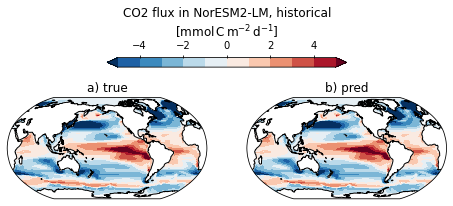

In [78]:
%%time
print(datetime.datetime.now())
print('NorESM2-LM historical reconstructed and targeted CO2 flux: fig')

# Load data2plot
savedfile = dirout + 'data2plot-maps-reconstructed-targeted-co2flux-noresm2-lm-historical.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)        

#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
nrow = 1
ncol = 2
ccrsproj = ccrs.Robinson(central_longitude=-155)
fsize = (10*cm2in*2, 5*cm2in*2) # width height
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, 
                       subplot_kw=dict(projection=ccrsproj),
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#-----------------
# CREATE CUSTOM CMAP
#-----------------

zw = cm.get_cmap('RdBu_r', 256)
newcolors = zw(np.linspace(0, 1, 10+2))
cmap = ListedColormap(newcolors[1:-1])
cmap.set_under(color=newcolors[0])
cmap.set_over (color=newcolors[-1])
cmap.set_bad(color='silver', alpha=0)
    
#-----------------
# KEYWORDS DICT
#-----------------

kwmap = {'vmin':-5, 'vmax':5, 'cmap':cmap, \
         'transform':ccrs.PlateCarree() }

#-----------------
# MAPS
#-----------------

irow = 0
icol = 0
for vvv in ['true', 'pred']: 
    zax = ax[irow, icol]
    X = data2plot['X']
    Y = data2plot['Y']
    Z = data2plot[vvv]
    pcm = zax.pcolormesh(X, Y, Z, **kwmap)   
    zax.set_title(subnum.pop() + ') ' + vvv)
    zax.coastlines()
    icol+=1
#


#---------------------
# Colorbar
#---------------------

zw1 = ax[0, 0].get_position()
zw2 = ax[0, -1].get_position()
nx0 = zw1.x0+.5*zw1.width
ny0 = zw1.y1 + .3*zw1.height
nw  = zw2.x0 + .5*zw2.width - nx0
nh  = 0.08*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal', \
                    ticklocation='top', extend='both')
cbar.set_label('CO2 flux in NorESM2-LM, historical\n[mmol$\,$C$\,$m$^{-2}\,$d$^{-1}$]', size=12)


#---------------------
# Save figure
#---------------------

fignam = 'maps-reconstructed-targeted-co2flux-noresm2-lm-historical.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# 10s

# Analysis of regression with MLD and EPC100 in NorESM2-LM, preindustrial

## Inputs

In [6]:
%%time
print(datetime.datetime.now())
print('Analysis of regression with MLD and EPC100 in NorESM2-LM, preindustrial: inputs')

dirin = '/mnt/reef-ns1002k/daco/DATA_FROM_KLAUS/TEST-MLD-EPC100/'
vmodel = 'NorESM2-LM'
vsimu  = 'picontrol'
grid       = '360x180'

2023-06-30 13:18:52.730626
Analysis of regression with MLD and EPC100 in NorESM2-LM, preindustrial: inputs
CPU times: user 0 ns, sys: 54 µs, total: 54 µs
Wall time: 61.5 µs


## Load, rearange datas and save to pickle

In [9]:
%%time
print(datetime.datetime.now())
print('Analysis of regression with MLD and EPC100 in NorESM2-LM, preindustrial: load, rearange datas and save to pickle')


#------------------
# LOAD DATA
#------------------

fname = dirin + 'results_' + vmodel + '-' + vsimu + '-' + grid + '/' + \
    vmodel + '-' + vsimu + '-' + grid + '.npy'
print('Read: '+fname)
results = np.load(fname, allow_pickle=True)

first_valid_entry = -1
for k in range(results.shape[0]):
    if results[k, 4][2] is not None:
        first_valid_entry = k
        break
assert(first_valid_entry >= 0)

#------------------
# DEFINE LAT, LON, MON
#------------------

n_lon = results[first_valid_entry,0]
n_lat = results[first_valid_entry,1]
n_mon = results[first_valid_entry,4][2][:,0].shape[0]
hx = 360 / n_lon
hy = 180 / n_lat

mid_points = np.zeros((results.shape[0], 2))
lon = np.zeros((results.shape[0]))
lat = np.zeros((results.shape[0]))  

for k_entry in range(results.shape[0]): # loop on grid point            
    zwlon = results[k_entry, 2]
    zwlat = results[k_entry, 3]
    mid_points[k_entry, 0] = (0.5 + zwlon) * hx - 180
    mid_points[k_entry, 1] = (0.5 + zwlat) * hy - 90
    lon[k_entry] = zwlon * hx - 180
    lat[k_entry] = zwlat * hy - 90            
#

# reshape datas
lon    = np.reshape(lon, (n_lon, n_lat))
lat    = np.reshape(lat, (n_lon, n_lat))

#------------------
# SCORE AND TRUE AND PREDICTED SIGNAL
#------------------

totscor_avg = np.zeros((results.shape[0]))
totscor_std = np.zeros((results.shape[0]))
cfxtrue = np.zeros((results.shape[0], n_mon))
cfxpred = np.zeros((results.shape[0], n_mon))
cfxstd  = np.zeros((results.shape[0], n_mon))

for k_entry in range(results.shape[0]): # loop on grid point

    #__________________
    # TRUE AND PRED SIGNALS
    if results[k_entry, 4][2] is not None:
        cfxtrue[k_entry] = results[k_entry, 4][2][:, 0].data
        cfxpred[k_entry] = results[k_entry, 4][2][:, 1].data
        cfxstd [k_entry] = results[k_entry, 4][2][:, 2].data
    else:
        cfxtrue[k_entry] = float('nan')*cfxtrue[k_entry]
        cfxpred[k_entry] = float('nan')*cfxpred[k_entry]
        cfxstd [k_entry] = float('nan')*cfxstd [k_entry]
    #

    #__________________
    # SCORE
    if results[k_entry, 4][1] is not None:
        totscor_avg[k_entry] = results[k_entry, 4][1][0]['total score avg']
        totscor_std[k_entry] = results[k_entry, 4][1][0]['total score std']
    else:
        totscor_avg[k_entry] = float('nan')
        totscor_std[k_entry] = float('nan')
    #
#                  

# reshape datas
cfxtrue = np.reshape(cfxtrue, (n_lon, n_lat, n_mon))    
cfxpred = np.reshape(cfxpred, (n_lon, n_lat, n_mon))    
cfxstd  = np.reshape(cfxstd, (n_lon, n_lat, n_mon))    
totscor_avg = np.reshape(totscor_avg, (n_lon, n_lat))    
totscor_std = np.reshape(totscor_std, (n_lon, n_lat))    

# save

data2save = {}
data2save['lon'] = lon
data2save['lat'] = lat
data2save['cfxtrue'] = cfxtrue
data2save['cfxpred'] = cfxpred
data2save['cfxstd']  = cfxstd

savedfile = dirout + 'cfx-true-pred-std-' + vmodel+'-'+vsimu+'.pckl'
# savedfile = dirout + 'cfx-true-pred-no-std' + vmodel+'-'+vsimu+'.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2save, f1)
print("File saved: "+savedfile)        

data2save = {}
data2save['lon'] = lon
data2save['lat'] = lat
data2save['totscor_avg'] = totscor_avg
data2save['totscor_std'] = totscor_std

savedfile = dirout + 'score-' + vmodel+'-'+vsimu+'.pckl'
# savedfile = dirout + 'score-no-std-' + vmodel+'-'+vsimu+'.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2save, f1)
print("File saved: "+savedfile)        


#------------------
# FEATURE IMPORTANCE
#------------------

feature_names = results[first_valid_entry, 4][1][0]['fi'][0]
n_features = len(feature_names)

data2save = {}
data2save['lon'] = lon
data2save['lat'] = lat

for k_fi, name_fi in enumerate(feature_names): # loop on features

    fi_avg = np.zeros(results.shape[0])
    fi_std = np.zeros(results.shape[0])

    for k_entry in range(results.shape[0]): # loop on grid points
        if results[k_entry, 4][1] is not None:
            zw1 = results[k_entry, 4][1][0]['fi'][1]
            zw1 = zw1 / np.sum(zw1)
            fi_avg[k_entry] = zw1[k_fi]
            zw1 = results[k_entry,4][1][0]['fi'][2] / results[k_entry,4][1][0]['fi'][1] * 100
            fi_std[k_entry] = zw1[k_fi]
        else:
            fi_avg[k_entry] = float('nan')
            fi_std[k_entry] = float('nan')
        #
    #

    # reshape datas
    fi_avg = np.reshape(fi_avg, (n_lon, n_lat))    
    fi_std = np.reshape(fi_std, (n_lon, n_lat))    
    # make nan data
    fi_avg[fi_avg<0] = float('nan')
    fi_std[fi_avg<0] = float('nan')

    data2save[name_fi] = {}
    data2save[name_fi]['avg'] = fi_avg
    data2save[name_fi]['std'] = fi_std
#

savedfile = dirout + 'fi-' + vmodel+'-'+vsimu+'.pckl'
# savedfile = dirout + 'fi-no-std-' + vmodel+'-'+vsimu+'.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2save, f1)
print("File saved: "+savedfile)        

# 12s

2023-06-30 11:11:56.962763
Analysis of regression with MLD and EPC100 in NorESM2-LM, preindustrial: load, rearange datas and save to pickle
Read: /mnt/reef-ns1002k/daco/DATA_FROM_KLAUS/TEST-MLD-EPC100/results_NorESM2-LM-picontrol-360x180/NorESM2-LM-picontrol-360x180.npy
File saved: dimred-230621-figure-article-review1-v0/cfx-true-pred-std-NorESM2-LM-picontrol.pckl
File saved: dimred-230621-figure-article-review1-v0/score-NorESM2-LM-picontrol.pckl


<timed exec>:139: RuntimeWarning: divide by zero encountered in true_divide


File saved: dimred-230621-figure-article-review1-v0/fi-NorESM2-LM-picontrol.pckl
CPU times: user 9.14 s, sys: 1.8 s, total: 10.9 s
Wall time: 11 s


## Fig

2023-06-30 13:39:03.769259
Analysis of regression with MLD and EPC100 in NorESM2-LM, preindustrial: fig
> Load datas
File loaded: dimred-230621-figure-article-review1-v0/fi-NorESM2-LM-picontrol.pckl
> Load datas
File loaded: dimred-230621-figure-article-review1-v0/score-NorESM2-LM-picontrol.pckl
> Load datas
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/score-std-NorESM2-LM-picontrol-360x180.pckl
Figure saved: maps-analysis-with-without-mld-epc100-noresm2-lm-preindustrial.png
CPU times: user 1min, sys: 1.05 s, total: 1min 1s
Wall time: 1min


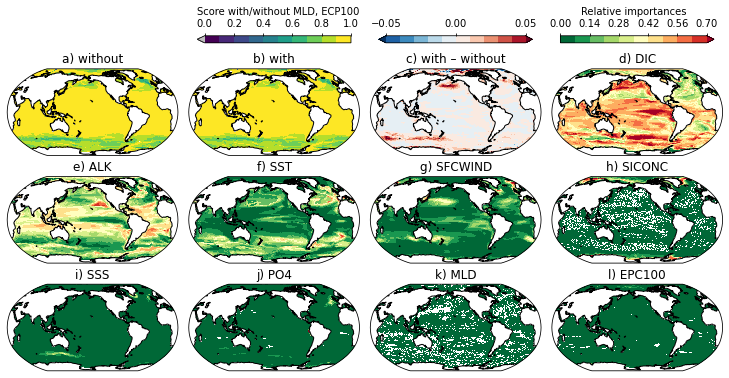

In [13]:
%%time
print(datetime.datetime.now())
print('Analysis of regression with MLD and EPC100 in NorESM2-LM, preindustrial: fig')

feature_list = ['dissic', 'talk', 'tos', 'sfcWind', 'siconc', 'sos', 'po4', 'mlotst', 'epc100']

#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
nrow = 3
ncol = 4
fsize = (26*cm2in, 12*cm2in) # width height
ccrsproj = ccrs.Robinson(central_longitude=-155)
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, 
                       subplot_kw=dict(projection=ccrsproj),
                       squeeze = False)

#-----------------
# DECORATION PARAM
#-----------------

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

feature_name = {
    'siconc' :'siconc', 
    'talk'   :'ALK',
    'dissic' :'DIC', 
    'tos'    :'SST', 
    'sfcWind':'sfcWind', 
    'sos'    :'SSS', 
    'po4'    :'PO4', 
    'atmco2' :'atmCO2',
    'mlotst' :'MLD', 
    'epc100' :'epc100'
}
simu_name = {
    'picontrol': 'preindustrial', 
    'historical': 'historical', 
    'ssp126': 'SSP126', 
    'ssp585': 'SSP585'
}

#-----------------
# CREATE CUSTOM CMAP
#-----------------

zw = cm.get_cmap('RdYlGn_r', 256)
newcolors = zw(np.linspace(0, 1, 10+1))
cmap1 = ListedColormap(newcolors[:-1])
cmap1.set_under(color='silver')
cmap1.set_over (color=newcolors[-1])
cmap1.set_bad(color='silver', alpha=0)

zw = cm.get_cmap('viridis', 256)
newcolors = zw(np.linspace(0, 1, 10))
cmap2 = ListedColormap(newcolors[:])
cmap2.set_under(color='silver')
cmap2.set_over(color='silver')
cmap2.set_bad(color='silver', alpha=0)

zw = cm.get_cmap('RdBu_r', 256)
newcolors = zw(np.linspace(0, 1, 10+2))
cmap3 = ListedColormap(newcolors[1:-1])
cmap3.set_under(color=newcolors[0])
cmap3.set_over(color=newcolors[-1])
cmap3.set_bad(color='silver', alpha=0)


#-----------------
# KEYWORDS DICT
#-----------------
kwmap = {}

kwmap['fi'] = {'vmin':0, 'vmax':0.7, 'cmap':cmap1, \
               'transform':ccrs.PlateCarree() }
kwmap['score'] = {'vmin':0, 'vmax':1, 'cmap':cmap2, \
                  'transform':ccrs.PlateCarree() }
kwmap['diff'] = {'vmin':-.05, 'vmax':.05, 'cmap':cmap3, \
                  'transform':ccrs.PlateCarree() }


#-----------------
# PREPARE DATA2PLOT
#-----------------

data2plot = {'fi':{}, 'score':{}}

#_________________
# Feature importances

print('> Load datas')
savedfile = dirout + 'fi-' + vmodel+'-'+vsimu+'.pckl'
with open(savedfile, 'rb') as f1: loadeddatas = pickle.load(f1)
print("File loaded: "+savedfile)
for ifeature, vfeature in enumerate(feature_list):             
    data2plot['fi'][vfeature] = {'X': loadeddatas['lon'].T, 
                                 'Y': loadeddatas['lat'].T, 
                                 'Z': loadeddatas[vfeature]['avg'].T}
    
#_________________
# Scores
print('> Load datas')
savedfile = dirout + 'score-' + vmodel+'-'+vsimu+'.pckl'
with open(savedfile, 'rb') as f1: loadeddatas = pickle.load(f1)
print("File loaded: "+savedfile)
data2plot['score']['X'  ] = loadeddatas['lon'].T 
data2plot['score']['Y'  ] = loadeddatas['lat'].T
data2plot['score']['new'] = loadeddatas['totscor_avg'].T

print('> Load datas')
savedfile = dirshared + 'score-std-' + vmodel+'-'+vsimu+'-'+grid+'.pckl'
with open(savedfile, 'rb') as f1: loadeddatas = pickle.load(f1)
print("File loaded: "+savedfile)
data2plot['score']['old'] = loadeddatas['totscor_avg'].T

#-----------------
# PLOT
#-----------------

mmm = np.zeros_like(ax)    

iplot = 0

X = data2plot['score']['X']
Y = data2plot['score']['Y']

zax = ax.flat[iplot]
Z = data2plot['score']['old']
mmm.flat[iplot] = zax.pcolormesh(X, Y, Z, **kwmap['score'])
zax.coastlines()
zwtitle = subnum.pop() + ') without'
zax.set_title(zwtitle, loc='center')
iplot+=1

zax = ax.flat[iplot]
Z = data2plot['score']['new']
mmm.flat[iplot] = zax.pcolormesh(X, Y, Z, **kwmap['score'])
zwtitle = subnum.pop() + ') with'
zax.set_title(zwtitle, loc='center')
zax.coastlines()
iplot+=1

zax = ax.flat[iplot]
Z = data2plot['score']['new'] - data2plot['score']['old']
mmm.flat[iplot] = zax.pcolormesh(X, Y, Z, **kwmap['diff'])
zwtitle = subnum.pop() + ') with – without'
zax.set_title(zwtitle, loc='center')
zax.coastlines()
iplot+=1

for ifeature, vfeature in enumerate(feature_list): 

    zax = ax.flat[iplot]
    X = data2plot['fi'][vfeature]['X']
    Y = data2plot['fi'][vfeature]['Y']
    Z = data2plot['fi'][vfeature]['Z']
    mmm.flat[iplot] = zax.pcolormesh(X, Y, Z, **kwmap['fi'])
    zwtitle = subnum.pop() + ') ' + feature_name[vfeature].upper()
    zax.set_title(zwtitle, loc='center')
    zax.coastlines()
    iplot+=1
    
#

fig.tight_layout()

#---------------------
# Colorbars
#---------------------

icol = 1
zw1 = ax[0,  icol].get_position()
nx0 = zw1.x0 + 0.05*zw1.width
ny0 = zw1.y1 + .3*zw1.height
nw  = 0.9*zw1.width
nh  = 0.1*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(mmm[0, icol], cax=cax, ticklocation='top', 
                    orientation='horizontal', extend='min', 
                    label='Score with/without MLD, ECP100')
cbar.set_ticks(np.linspace(kwmap['score']['vmin'], kwmap['score']['vmax'], int(mmm[0,icol].cmap.colors.shape[0]/2)+1))

icol = 2
zw1 = ax[0,  icol].get_position()
nx0 = zw1.x0 + 0.05*zw1.width
ny0 = zw1.y1 + .3*zw1.height
nw  = 0.9*zw1.width
nh  = 0.1*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(mmm[0, icol], cax=cax, ticklocation='top', 
                    orientation='horizontal', extend='both', 
                    label='')
cbar.set_ticks([kwmap['diff']['vmin'], 0,  kwmap['diff']['vmax']])

icol = 3
zw1 = ax[0,  icol].get_position()
nx0 = zw1.x0 + 0.05*zw1.width
ny0 = zw1.y1 + .3*zw1.height
nw  = 0.9*zw1.width
nh  = 0.1*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(mmm[0, icol], cax=cax, ticklocation='top', 
                    orientation='horizontal', extend='max', 
                    label='Relative importances')
cbar.set_ticks(np.linspace(kwmap['fi']['vmin'], kwmap['fi']['vmax'], int(mmm[0,icol].cmap.colors.shape[0]/2)+1))

#---------------------
# Save figure
#---------------------

fignam = 'maps-analysis-with-without-mld-epc100-noresm2-lm-preindustrial.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)


# ca. 57s


# Scatter plot reconstructed vs target

## Input

In [6]:
%%time
print(datetime.datetime.now())
print('Scatter plot reconstructed vs target: input')

model_list = ['ACCESS-ESM1-5', 'CESM2', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR', 'NorESM2-LM']
# vmodel = 'NorESM2-LM'
simu_list  = ['picontrol', 'historical', 'ssp126', 'ssp585']
# vsimu = 'historical'
#grid_list  = ['90x45', '180x90']
grid  = '360x180'

###############
###############
###############
zfact = 1e6*3600*24 # kmol/m2/s -> mmol/m2/d
###############
###############
###############

2023-07-26 16:25:03.185208
Scatter plot reconstructed vs target: input
CPU times: user 33 µs, sys: 28 µs, total: 61 µs
Wall time: 65.1 µs


## Prepare and save data2plot

In [8]:
%%time
print(datetime.datetime.now())
print('Scatter plot reconstructed vs target: prepare and save data2plot')

data2plot = {}

for imodel, vmodel in enumerate(model_list): 
   
    data2plot[vmodel] = {}

    for isimu, vsimu in enumerate(simu_list): 
        
        data2plot[vmodel][vsimu] = {}
        
        #_______________
        # Load datas
        savedfile = dirshared + 'cfx-true-pred-std-'+vmodel+'-'+vsimu+'-'+grid+'.pckl'
        with open(savedfile, 'rb') as f1: zwdata = pickle.load(f1)
        print("File loaded: "+savedfile)            

        cfxtrue = zwdata['cfxtrue'].T * zfact
        cfxpred = zwdata['cfxpred'].T * zfact        
        # lon = zwdata['lon'].T
        # lat = zwdata['lat'].T
        
        #_______________
        # detrend and deseasonalized      
        nt, ny, nx = cfxtrue.shape
        dtdstrue, trdseastrue, trdtrue, seastrue = [], [], [], []
        dtdspred, trdseaspred, trdpred, seaspred = [], [], [], []
        dtdspred2 = []
        t = np.linspace(0, nt - 1, num=nt)
        for jjj in np.arange(ny): 
            for iii in np.arange(nx): 
                if not np.isnan(cfxtrue[0, jjj, iii]): 
                    zwtrdtrue = p_smooth_spline(t, cfxtrue[:, jjj, iii])
                    zwdtdstrue, zwtrdseastrue, zwseastrue = dtrd_dseas(cfxtrue[:, jjj, iii], zwtrdtrue)
                    dtdstrue.extend(zwdtdstrue)
                    trdseastrue.extend(zwtrdseastrue)
                    trdtrue.extend(zwtrdtrue)
                    seastrue.extend(zwseastrue)
                #
                if not np.isnan(cfxpred[0, jjj, iii]): 
                    zwtrdpred = p_smooth_spline(t, cfxpred[:, jjj, iii])
                    zwdtdspred, zwtrdseaspred, zwseaspred = dtrd_dseas(cfxpred[:, jjj, iii], zwtrdpred)
                    zwdtdspred2 = cfxpred[:, jjj, iii] - zwtrdseastrue
                    dtdspred.extend(zwdtdspred)
                    trdseaspred.extend(zwtrdseaspred)
                    trdpred.extend(zwtrdpred)
                    seaspred.extend(zwseaspred)                    
                    dtdspred2.extend(zwdtdspred2)
                #
            #
        #

        #_______________
        # Compute histograms 2D
        
        # cfxtrue, cfxpred
        bounds = [[np.nanmin([cfxtrue.flatten(), cfxpred.flatten()]),
                   np.nanmax([cfxtrue.flatten(), cfxpred.flatten()])], 
                  [np.nanmin([cfxtrue.flatten(), cfxpred.flatten()]), 
                   np.nanmax([cfxtrue.flatten(), cfxpred.flatten()])]]
        nbin=500
        hhh = histogram2d(cfxtrue.flatten(), cfxpred.flatten(), range=bounds, bins=nbin)
        xxx = np.linspace(bounds[0][0], bounds[0][1], nbin)
        yyy = np.linspace(bounds[1][0], bounds[1][1], nbin)
        data2plot[vmodel][vsimu]['cfx'] = {'X':xxx, 'Y':yyy, 'Z':hhh}

        # dtdstrue, dtdspred2
        bounds = [[np.nanmin([dtdstrue, dtdspred2]),
                   np.nanmax([dtdstrue, dtdspred2])], 
                  [np.nanmin([dtdstrue, dtdspred2]), 
                   np.nanmax([dtdstrue, dtdspred2])]]
        nbin=500
        hhh = histogram2d(dtdstrue, dtdspred2, range=bounds, bins=nbin)
        xxx = np.linspace(bounds[0][0], bounds[0][1], nbin)
        yyy = np.linspace(bounds[1][0], bounds[1][1], nbin)
        data2plot[vmodel][vsimu]['dtds2'] = {'X':xxx, 'Y':yyy, 'Z':hhh}

        # dtdstrue, dtdspred
        bounds = [[np.nanmin([dtdstrue, dtdspred]),
                   np.nanmax([dtdstrue, dtdspred])], 
                  [np.nanmin([dtdstrue, dtdspred]), 
                   np.nanmax([dtdstrue, dtdspred])]]
        nbin=500
        hhh = histogram2d(dtdstrue, dtdspred, range=bounds, bins=nbin)
        xxx = np.linspace(bounds[0][0], bounds[0][1], nbin)
        yyy = np.linspace(bounds[1][0], bounds[1][1], nbin)
        data2plot[vmodel][vsimu]['dtds'] = {'X':xxx, 'Y':yyy, 'Z':hhh}

        # trdtrue, trdpred
        bounds = [[np.nanmin([trdtrue, trdpred]),
                   np.nanmax([trdtrue, trdpred])], 
                  [np.nanmin([trdtrue, trdpred]), 
                   np.nanmax([trdtrue, trdpred])]]
        nbin=500
        hhh = histogram2d(trdtrue, trdpred, range=bounds, bins=nbin)
        xxx = np.linspace(bounds[0][0], bounds[0][1], nbin)
        yyy = np.linspace(bounds[1][0], bounds[1][1], nbin)
        data2plot[vmodel][vsimu]['trd'] = {'X':xxx, 'Y':yyy, 'Z':hhh}
        
        # seastrue, seaspred
        bounds = [[np.nanmin([seastrue, seaspred]),
                   np.nanmax([seastrue, seaspred])], 
                  [np.nanmin([seastrue, seaspred]), 
                   np.nanmax([seastrue, seaspred])]]
        nbin=500
        hhh = histogram2d(seastrue, seaspred, range=bounds, bins=nbin)
        xxx = np.linspace(bounds[0][0], bounds[0][1], nbin)
        yyy = np.linspace(bounds[1][0], bounds[1][1], nbin)
        data2plot[vmodel][vsimu]['seas'] = {'X':xxx, 'Y':yyy, 'Z':hhh}

        # trdseastrue, trdseaspred
        bounds = [[np.nanmin([trdseastrue, trdseaspred]),
                   np.nanmax([trdseastrue, trdseaspred])], 
                  [np.nanmin([trdseastrue, trdseaspred]), 
                   np.nanmax([trdseastrue, trdseaspred])]]
        nbin=500
        hhh = histogram2d(trdseastrue, trdseaspred, range=bounds, bins=nbin)
        xxx = np.linspace(bounds[0][0], bounds[0][1], nbin)
        yyy = np.linspace(bounds[1][0], bounds[1][1], nbin)
        data2plot[vmodel][vsimu]['trdseas'] = {'X':xxx, 'Y':yyy, 'Z':hhh}

    #
#

savedfile = dirout + 'scatter-rec-vs-target.pckl'
# savedfile = dirout + 'fi-no-std-' + vmodel+'-'+vsimu+'.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("File saved: "+savedfile)        


2023-07-26 16:25:17.892835
Scatter plot reconstructed vs target: prepare and save data2plot
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-ACCESS-ESM1-5-picontrol-360x180.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-ACCESS-ESM1-5-historical-360x180.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-ACCESS-ESM1-5-ssp126-360x180.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-ACCESS-ESM1-5-ssp585-360x180.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-CESM2-picontrol-360x180.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-CESM2-historical-360x180.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-CESM2-ssp126-360x180.pckl
File loa

## Fig

### cfx

2023-07-26 19:34:31.619946
Scatter plot reconstructed vs target: fig cfx
File loaded: dimred-230621-figure-article-review1-v0/scatter-rec-vs-target.pckl
Figure saved: scatter-rec-vs-target-cfx.png
CPU times: user 8.02 s, sys: 1.2 s, total: 9.22 s
Wall time: 8.19 s


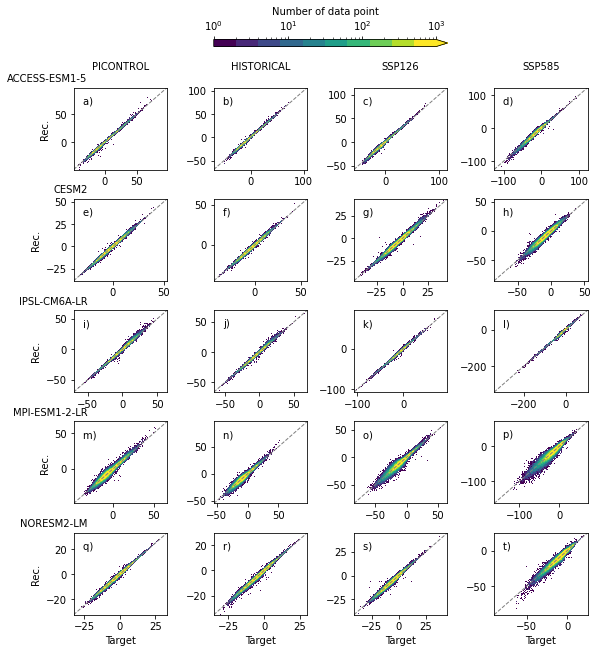

In [10]:
%%time
print(datetime.datetime.now())

select_processed_histogram = 'cfx'
print('Scatter plot reconstructed vs target: fig '+select_processed_histogram)

#-----------------
# Load data2plot
#-----------------

savedfile = dirout + 'scatter-rec-vs-target.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)       

#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
nrow = len(model_list)
ncol = len(simu_list)
fsize = (20*cm2in, 20*cm2in) # width height
fig, ax = plt.subplots(nrow, ncol, figsize=fsize,
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#-----------------
# CREATE CUSTOM CMAP
#-----------------

cmap = cm.get_cmap('viridis', 256)
newcolors = cmap(np.linspace(0, 1, 10))
cmap = ListedColormap(newcolors[:])
cmap.set_under(color='silver')
# cmap.set_over(color='silver')
cmap.set_bad(color='silver', alpha=0)


#---------------------
# PLOT 2D HISTOGRAMS
#---------------------

pcm = np.zeros_like(ax)

for imodel, vmodel in enumerate(model_list): 
    
    for isimu, vsimu in enumerate(simu_list): 
               
       
        zax = ax[imodel, isimu]
        pcm[imodel, isimu] = zax.pcolormesh(data2plot[vmodel][vsimu][select_processed_histogram]['X'], 
                                            data2plot[vmodel][vsimu][select_processed_histogram]['Y'],
                                            data2plot[vmodel][vsimu][select_processed_histogram]['Z'], 
                                            norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap=cmap)
        ybounds = zax.yaxis.get_data_interval()
        xbounds = zax.xaxis.get_data_interval()
        bbb = [np.nanmin([ybounds[0], xbounds[0]]), np.nanmax([ybounds[1], xbounds[1]])]
        zax.plot(bbb, bbb, lw=1, c='gray', ls='--')
        
        
    #
#

fig.tight_layout()

#---------------------
# Add numbering to titles of subplots
#---------------------

for irow, axrow in enumerate(ax): 
    for zax in axrow: 
        zwtitle = subnum.pop() + ') '
        zax.annotate(zwtitle, (0.1, 0.8),xycoords='axes fraction')

    #
#

#---------------------
# Add text on the left: model names
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', weight='normal', ha='right', va='bottom')
for imodel, vmodel in enumerate(model_list): 
    zw1 = ax[imodel, 0].get_position()
    ny0 = zw1.y1 + .05*zw1.height
    nx0 = zw1.x0 + .15*zw1.width
    fig.text(nx0, ny0, vmodel.upper(), **kwtxt)
#

#---------------------
# Add text on the top: simu names
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', weight='normal', ha='center', va='bottom')
for isimu, vsimu in enumerate(simu_list): 
    zw1 = ax[0, isimu].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .2*zw1.height
    fig.text(nx0, ny0, vsimu.upper(), **kwtxt)
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[0, 1].get_position()
zw2 = ax[0, 2].get_position()
nx0 = zw1.x0
ny0 = zw1.y1 + .5*zw1.height
nw  = zw2.x1 - nx0
nh  = 0.03*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm[0, 0], cax=cax, orientation='horizontal', \
                    ticklocation='top', extend='max')
cbar.set_label(r'Number of data point')

#---------------------
# Add x and ylabel
#---------------------

for iax, zax in enumerate(ax[:, 0]): zax.set_ylabel('Rec.')
for iax, zax in enumerate(ax[-1, :]): zax.set_xlabel('Target')

#---------------------
# Save figure
#---------------------

fignam = 'scatter-rec-vs-target-'+select_processed_histogram+'.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# ca. 1m

### dtds

2023-07-26 19:34:53.645530
Scatter plot reconstructed vs target: fig dtds
File loaded: dimred-230621-figure-article-review1-v0/scatter-rec-vs-target.pckl
Figure saved: scatter-rec-vs-target-dtds.png
CPU times: user 4.61 s, sys: 1.06 s, total: 5.67 s
Wall time: 4.6 s


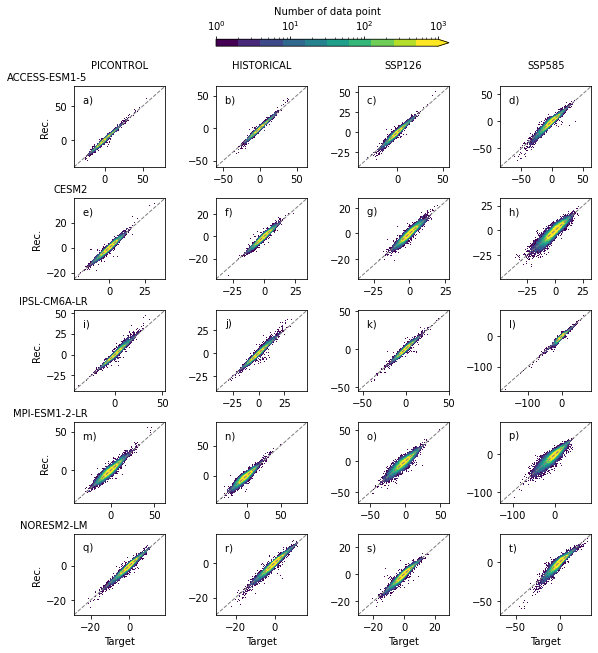

In [11]:
%%time
print(datetime.datetime.now())

select_processed_histogram = 'dtds'
print('Scatter plot reconstructed vs target: fig '+select_processed_histogram)

#-----------------
# Load data2plot
#-----------------

savedfile = dirout + 'scatter-rec-vs-target.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)       

#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
nrow = len(model_list)
ncol = len(simu_list)
fsize = (20*cm2in, 20*cm2in) # width height
fig, ax = plt.subplots(nrow, ncol, figsize=fsize,
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#-----------------
# CREATE CUSTOM CMAP
#-----------------

cmap = cm.get_cmap('viridis', 256)
newcolors = cmap(np.linspace(0, 1, 10))
cmap = ListedColormap(newcolors[:])
cmap.set_under(color='silver')
# cmap.set_over(color='silver')
cmap.set_bad(color='silver', alpha=0)


#---------------------
# PLOT 2D HISTOGRAMS
#---------------------

pcm = np.zeros_like(ax)

for imodel, vmodel in enumerate(model_list): 
    
    for isimu, vsimu in enumerate(simu_list): 
               
       
        zax = ax[imodel, isimu]
        pcm[imodel, isimu] = zax.pcolormesh(data2plot[vmodel][vsimu][select_processed_histogram]['X'], 
                                            data2plot[vmodel][vsimu][select_processed_histogram]['Y'],
                                            data2plot[vmodel][vsimu][select_processed_histogram]['Z'], 
                                            norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap=cmap)
        ybounds = zax.yaxis.get_data_interval()
        xbounds = zax.xaxis.get_data_interval()
        bbb = [np.nanmin([ybounds[0], xbounds[0]]), np.nanmax([ybounds[1], xbounds[1]])]
        zax.plot(bbb, bbb, lw=1, c='gray', ls='--')
        
        
    #
#

fig.tight_layout()

#---------------------
# Add numbering to titles of subplots
#---------------------

for irow, axrow in enumerate(ax): 
    for zax in axrow: 
        zwtitle = subnum.pop() + ') '
        zax.annotate(zwtitle, (0.1, 0.8),xycoords='axes fraction')

    #
#

#---------------------
# Add text on the left: model names
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', weight='normal', ha='right', va='bottom')
for imodel, vmodel in enumerate(model_list): 
    zw1 = ax[imodel, 0].get_position()
    ny0 = zw1.y1 + .05*zw1.height
    nx0 = zw1.x0 + .15*zw1.width
    fig.text(nx0, ny0, vmodel.upper(), **kwtxt)
#

#---------------------
# Add text on the top: simu names
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', weight='normal', ha='center', va='bottom')
for isimu, vsimu in enumerate(simu_list): 
    zw1 = ax[0, isimu].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .2*zw1.height
    fig.text(nx0, ny0, vsimu.upper(), **kwtxt)
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[0, 1].get_position()
zw2 = ax[0, 2].get_position()
nx0 = zw1.x0
ny0 = zw1.y1 + .5*zw1.height
nw  = zw2.x1 - nx0
nh  = 0.03*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm[0, 0], cax=cax, orientation='horizontal', \
                    ticklocation='top', extend='max')
cbar.set_label(r'Number of data point')

#---------------------
# Add x and ylabel
#---------------------

for iax, zax in enumerate(ax[:, 0]): zax.set_ylabel('Rec.')
for iax, zax in enumerate(ax[-1, :]): zax.set_xlabel('Target')

#---------------------
# Save figure
#---------------------

fignam = 'scatter-rec-vs-target-'+select_processed_histogram+'.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# ca. 1m

### dtds2

2023-07-26 19:35:05.317367
Scatter plot reconstructed vs target: fig dtds2
File loaded: dimred-230621-figure-article-review1-v0/scatter-rec-vs-target.pckl
Figure saved: scatter-rec-vs-target-dtds2.png
CPU times: user 6.43 s, sys: 1.34 s, total: 7.78 s
Wall time: 6.72 s


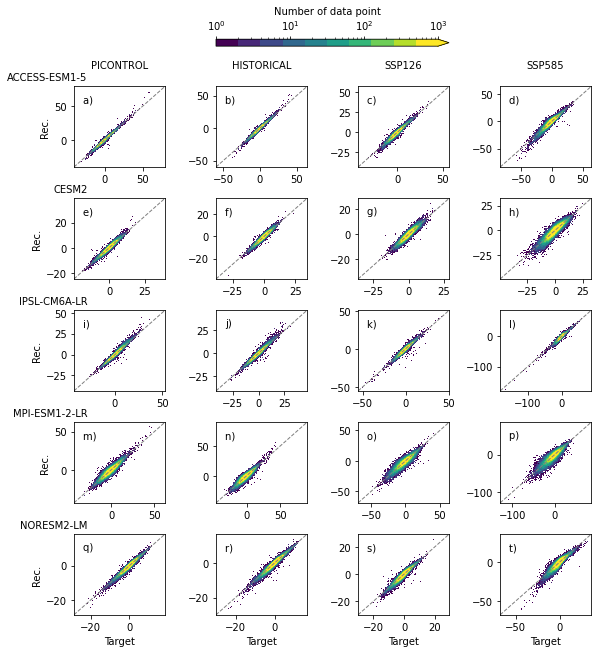

In [12]:
%%time
print(datetime.datetime.now())

select_processed_histogram = 'dtds2'
print('Scatter plot reconstructed vs target: fig '+select_processed_histogram)

#-----------------
# Load data2plot
#-----------------

savedfile = dirout + 'scatter-rec-vs-target.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)       

#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
nrow = len(model_list)
ncol = len(simu_list)
fsize = (20*cm2in, 20*cm2in) # width height
fig, ax = plt.subplots(nrow, ncol, figsize=fsize,
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#-----------------
# CREATE CUSTOM CMAP
#-----------------

cmap = cm.get_cmap('viridis', 256)
newcolors = cmap(np.linspace(0, 1, 10))
cmap = ListedColormap(newcolors[:])
cmap.set_under(color='silver')
# cmap.set_over(color='silver')
cmap.set_bad(color='silver', alpha=0)


#---------------------
# PLOT 2D HISTOGRAMS
#---------------------

pcm = np.zeros_like(ax)

for imodel, vmodel in enumerate(model_list): 
    
    for isimu, vsimu in enumerate(simu_list): 
               
       
        zax = ax[imodel, isimu]
        pcm[imodel, isimu] = zax.pcolormesh(data2plot[vmodel][vsimu][select_processed_histogram]['X'], 
                                            data2plot[vmodel][vsimu][select_processed_histogram]['Y'],
                                            data2plot[vmodel][vsimu][select_processed_histogram]['Z'], 
                                            norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap=cmap)
        ybounds = zax.yaxis.get_data_interval()
        xbounds = zax.xaxis.get_data_interval()
        bbb = [np.nanmin([ybounds[0], xbounds[0]]), np.nanmax([ybounds[1], xbounds[1]])]
        zax.plot(bbb, bbb, lw=1, c='gray', ls='--')
        
        
    #
#

fig.tight_layout()

#---------------------
# Add numbering to titles of subplots
#---------------------

for irow, axrow in enumerate(ax): 
    for zax in axrow: 
        zwtitle = subnum.pop() + ') '
        zax.annotate(zwtitle, (0.1, 0.8),xycoords='axes fraction')

    #
#

#---------------------
# Add text on the left: model names
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', weight='normal', ha='right', va='bottom')
for imodel, vmodel in enumerate(model_list): 
    zw1 = ax[imodel, 0].get_position()
    ny0 = zw1.y1 + .05*zw1.height
    nx0 = zw1.x0 + .15*zw1.width
    fig.text(nx0, ny0, vmodel.upper(), **kwtxt)
#

#---------------------
# Add text on the top: simu names
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', weight='normal', ha='center', va='bottom')
for isimu, vsimu in enumerate(simu_list): 
    zw1 = ax[0, isimu].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .2*zw1.height
    fig.text(nx0, ny0, vsimu.upper(), **kwtxt)
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[0, 1].get_position()
zw2 = ax[0, 2].get_position()
nx0 = zw1.x0
ny0 = zw1.y1 + .5*zw1.height
nw  = zw2.x1 - nx0
nh  = 0.03*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm[0, 0], cax=cax, orientation='horizontal', \
                    ticklocation='top', extend='max')
cbar.set_label(r'Number of data point')

#---------------------
# Add x and ylabel
#---------------------

for iax, zax in enumerate(ax[:, 0]): zax.set_ylabel('Rec.')
for iax, zax in enumerate(ax[-1, :]): zax.set_xlabel('Target')

#---------------------
# Save figure
#---------------------

fignam = 'scatter-rec-vs-target-'+select_processed_histogram+'.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# ca. 1m

### trd

2023-07-26 19:35:59.896297
Scatter plot reconstructed vs target: fig trd
File loaded: dimred-230621-figure-article-review1-v0/scatter-rec-vs-target.pckl
Figure saved: scatter-rec-vs-target-trd.png
CPU times: user 6.4 s, sys: 1.09 s, total: 7.49 s
Wall time: 6.43 s


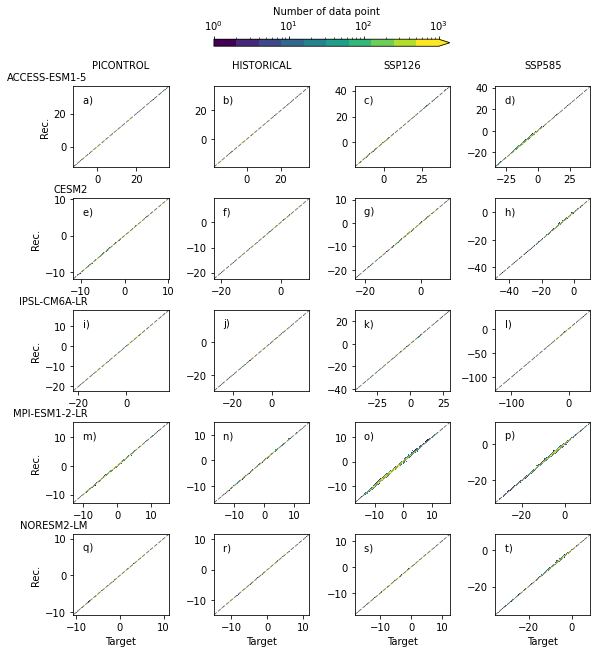

In [13]:
%%time
print(datetime.datetime.now())

select_processed_histogram = 'trd'
print('Scatter plot reconstructed vs target: fig '+select_processed_histogram)

#-----------------
# Load data2plot
#-----------------

savedfile = dirout + 'scatter-rec-vs-target.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)       

#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
nrow = len(model_list)
ncol = len(simu_list)
fsize = (20*cm2in, 20*cm2in) # width height
fig, ax = plt.subplots(nrow, ncol, figsize=fsize,
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#-----------------
# CREATE CUSTOM CMAP
#-----------------

cmap = cm.get_cmap('viridis', 256)
newcolors = cmap(np.linspace(0, 1, 10))
cmap = ListedColormap(newcolors[:])
cmap.set_under(color='silver')
# cmap.set_over(color='silver')
cmap.set_bad(color='silver', alpha=0)


#---------------------
# PLOT 2D HISTOGRAMS
#---------------------

pcm = np.zeros_like(ax)

for imodel, vmodel in enumerate(model_list): 
    
    for isimu, vsimu in enumerate(simu_list): 
               
       
        zax = ax[imodel, isimu]
        pcm[imodel, isimu] = zax.pcolormesh(data2plot[vmodel][vsimu][select_processed_histogram]['X'], 
                                            data2plot[vmodel][vsimu][select_processed_histogram]['Y'],
                                            data2plot[vmodel][vsimu][select_processed_histogram]['Z'], 
                                            norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap=cmap)
        ybounds = zax.yaxis.get_data_interval()
        xbounds = zax.xaxis.get_data_interval()
        bbb = [np.nanmin([ybounds[0], xbounds[0]]), np.nanmax([ybounds[1], xbounds[1]])]
        zax.plot(bbb, bbb, lw=1, c='gray', ls='--')
        
        
    #
#

fig.tight_layout()

#---------------------
# Add numbering to titles of subplots
#---------------------

for irow, axrow in enumerate(ax): 
    for zax in axrow: 
        zwtitle = subnum.pop() + ') '
        zax.annotate(zwtitle, (0.1, 0.8),xycoords='axes fraction')

    #
#

#---------------------
# Add text on the left: model names
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', weight='normal', ha='right', va='bottom')
for imodel, vmodel in enumerate(model_list): 
    zw1 = ax[imodel, 0].get_position()
    ny0 = zw1.y1 + .05*zw1.height
    nx0 = zw1.x0 + .15*zw1.width
    fig.text(nx0, ny0, vmodel.upper(), **kwtxt)
#

#---------------------
# Add text on the top: simu names
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', weight='normal', ha='center', va='bottom')
for isimu, vsimu in enumerate(simu_list): 
    zw1 = ax[0, isimu].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .2*zw1.height
    fig.text(nx0, ny0, vsimu.upper(), **kwtxt)
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[0, 1].get_position()
zw2 = ax[0, 2].get_position()
nx0 = zw1.x0
ny0 = zw1.y1 + .5*zw1.height
nw  = zw2.x1 - nx0
nh  = 0.03*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm[0, 0], cax=cax, orientation='horizontal', \
                    ticklocation='top', extend='max')
cbar.set_label(r'Number of data point')

#---------------------
# Add x and ylabel
#---------------------

for iax, zax in enumerate(ax[:, 0]): zax.set_ylabel('Rec.')
for iax, zax in enumerate(ax[-1, :]): zax.set_xlabel('Target')

#---------------------
# Save figure
#---------------------

fignam = 'scatter-rec-vs-target-'+select_processed_histogram+'.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# ca. 1m

### seas

2023-07-26 19:36:18.378912
Scatter plot reconstructed vs target: fig seas
File loaded: dimred-230621-figure-article-review1-v0/scatter-rec-vs-target.pckl
Figure saved: scatter-rec-vs-target-seas.png
CPU times: user 6.59 s, sys: 1.29 s, total: 7.88 s
Wall time: 6.82 s


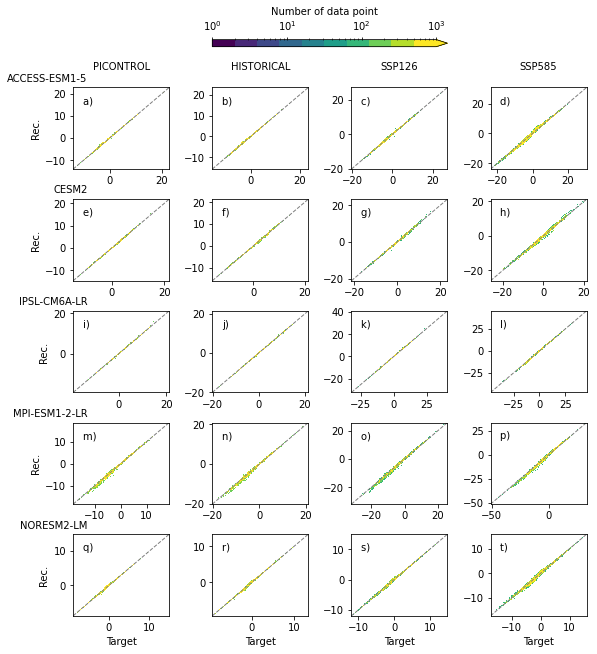

In [14]:
%%time
print(datetime.datetime.now())

select_processed_histogram = 'seas'
print('Scatter plot reconstructed vs target: fig '+select_processed_histogram)


#-----------------
# Load data2plot
#-----------------

savedfile = dirout + 'scatter-rec-vs-target.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)       

#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
nrow = len(model_list)
ncol = len(simu_list)
fsize = (20*cm2in, 20*cm2in) # width height
fig, ax = plt.subplots(nrow, ncol, figsize=fsize,
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#-----------------
# CREATE CUSTOM CMAP
#-----------------

cmap = cm.get_cmap('viridis', 256)
newcolors = cmap(np.linspace(0, 1, 10))
cmap = ListedColormap(newcolors[:])
cmap.set_under(color='silver')
# cmap.set_over(color='silver')
cmap.set_bad(color='silver', alpha=0)


#---------------------
# PLOT 2D HISTOGRAMS
#---------------------

pcm = np.zeros_like(ax)

for imodel, vmodel in enumerate(model_list): 
    
    for isimu, vsimu in enumerate(simu_list): 
               
       
        zax = ax[imodel, isimu]
        pcm[imodel, isimu] = zax.pcolormesh(data2plot[vmodel][vsimu][select_processed_histogram]['X'], 
                                            data2plot[vmodel][vsimu][select_processed_histogram]['Y'],
                                            data2plot[vmodel][vsimu][select_processed_histogram]['Z'], 
                                            norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap=cmap)
        ybounds = zax.yaxis.get_data_interval()
        xbounds = zax.xaxis.get_data_interval()
        bbb = [np.nanmin([ybounds[0], xbounds[0]]), np.nanmax([ybounds[1], xbounds[1]])]
        zax.plot(bbb, bbb, lw=1, c='gray', ls='--')
        
        
    #
#

fig.tight_layout()

#---------------------
# Add numbering to titles of subplots
#---------------------

for irow, axrow in enumerate(ax): 
    for zax in axrow: 
        zwtitle = subnum.pop() + ') '
        zax.annotate(zwtitle, (0.1, 0.8),xycoords='axes fraction')

    #
#

#---------------------
# Add text on the left: model names
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', weight='normal', ha='right', va='bottom')
for imodel, vmodel in enumerate(model_list): 
    zw1 = ax[imodel, 0].get_position()
    ny0 = zw1.y1 + .05*zw1.height
    nx0 = zw1.x0 + .15*zw1.width
    fig.text(nx0, ny0, vmodel.upper(), **kwtxt)
#

#---------------------
# Add text on the top: simu names
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', weight='normal', ha='center', va='bottom')
for isimu, vsimu in enumerate(simu_list): 
    zw1 = ax[0, isimu].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .2*zw1.height
    fig.text(nx0, ny0, vsimu.upper(), **kwtxt)
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[0, 1].get_position()
zw2 = ax[0, 2].get_position()
nx0 = zw1.x0
ny0 = zw1.y1 + .5*zw1.height
nw  = zw2.x1 - nx0
nh  = 0.03*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm[0, 0], cax=cax, orientation='horizontal', \
                    ticklocation='top', extend='max')
cbar.set_label(r'Number of data point')

#---------------------
# Add x and ylabel
#---------------------

for iax, zax in enumerate(ax[:, 0]): zax.set_ylabel('Rec.')
for iax, zax in enumerate(ax[-1, :]): zax.set_xlabel('Target')

#---------------------
# Save figure
#---------------------

fignam = 'scatter-rec-vs-target-'+select_processed_histogram+'.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# ca. 1m

### trdseas

2023-07-26 19:36:39.831939
Scatter plot reconstructed vs target: fig trdseas
File loaded: dimred-230621-figure-article-review1-v0/scatter-rec-vs-target.pckl
Figure saved: scatter-rec-vs-target-trdseas.png
CPU times: user 4.64 s, sys: 1.01 s, total: 5.65 s
Wall time: 4.58 s


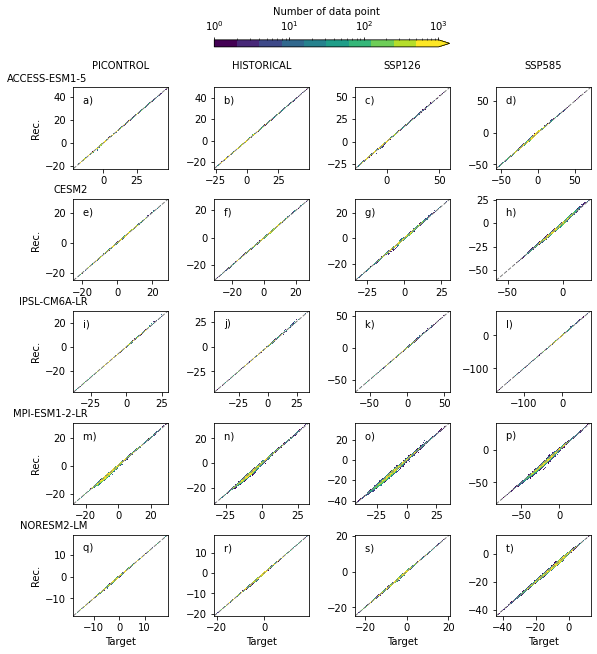

In [15]:
%%time
print(datetime.datetime.now())

select_processed_histogram = 'trdseas'
print('Scatter plot reconstructed vs target: fig '+select_processed_histogram)

#-----------------
# Load data2plot
#-----------------

savedfile = dirout + 'scatter-rec-vs-target.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)       

#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
nrow = len(model_list)
ncol = len(simu_list)
fsize = (20*cm2in, 20*cm2in) # width height
fig, ax = plt.subplots(nrow, ncol, figsize=fsize,
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#-----------------
# CREATE CUSTOM CMAP
#-----------------

cmap = cm.get_cmap('viridis', 256)
newcolors = cmap(np.linspace(0, 1, 10))
cmap = ListedColormap(newcolors[:])
cmap.set_under(color='silver')
# cmap.set_over(color='silver')
cmap.set_bad(color='silver', alpha=0)


#---------------------
# PLOT 2D HISTOGRAMS
#---------------------

pcm = np.zeros_like(ax)

for imodel, vmodel in enumerate(model_list): 
    
    for isimu, vsimu in enumerate(simu_list): 
               
       
        zax = ax[imodel, isimu]
        pcm[imodel, isimu] = zax.pcolormesh(data2plot[vmodel][vsimu][select_processed_histogram]['X'], 
                                            data2plot[vmodel][vsimu][select_processed_histogram]['Y'],
                                            data2plot[vmodel][vsimu][select_processed_histogram]['Z'], 
                                            norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap=cmap)
        ybounds = zax.yaxis.get_data_interval()
        xbounds = zax.xaxis.get_data_interval()
        bbb = [np.nanmin([ybounds[0], xbounds[0]]), np.nanmax([ybounds[1], xbounds[1]])]
        zax.plot(bbb, bbb, lw=1, c='gray', ls='--')
        
        
    #
#

fig.tight_layout()

#---------------------
# Add numbering to titles of subplots
#---------------------

for irow, axrow in enumerate(ax): 
    for zax in axrow: 
        zwtitle = subnum.pop() + ') '
        zax.annotate(zwtitle, (0.1, 0.8),xycoords='axes fraction')

    #
#

#---------------------
# Add text on the left: model names
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', weight='normal', ha='right', va='bottom')
for imodel, vmodel in enumerate(model_list): 
    zw1 = ax[imodel, 0].get_position()
    ny0 = zw1.y1 + .05*zw1.height
    nx0 = zw1.x0 + .15*zw1.width
    fig.text(nx0, ny0, vmodel.upper(), **kwtxt)
#

#---------------------
# Add text on the top: simu names
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', weight='normal', ha='center', va='bottom')
for isimu, vsimu in enumerate(simu_list): 
    zw1 = ax[0, isimu].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .2*zw1.height
    fig.text(nx0, ny0, vsimu.upper(), **kwtxt)
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[0, 1].get_position()
zw2 = ax[0, 2].get_position()
nx0 = zw1.x0
ny0 = zw1.y1 + .5*zw1.height
nw  = zw2.x1 - nx0
nh  = 0.03*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm[0, 0], cax=cax, orientation='horizontal', \
                    ticklocation='top', extend='max')
cbar.set_label(r'Number of data point')

#---------------------
# Add x and ylabel
#---------------------

for iax, zax in enumerate(ax[:, 0]): zax.set_ylabel('Rec.')
for iax, zax in enumerate(ax[-1, :]): zax.set_xlabel('Target')

#---------------------
# Save figure
#---------------------

fignam = 'scatter-rec-vs-target-'+select_processed_histogram+'.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# ca. 1m

# Scatter plot reconstructed vs target focus

## Input

In [20]:
%%time
print(datetime.datetime.now())
print('Scatter plot reconstructed vs target focus: input')

# model_list = ['ACCESS-ESM1-5', 'CESM2', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR', 'NorESM2-LM']
vmodel = 'NorESM2-LM'
simu_list  = ['picontrol', 'historical', 'ssp126', 'ssp585']
# vsimu = 'historical'
#grid_list  = ['90x45', '180x90']
grid  = '360x180'

latbox = {'SO': [-60, -40], 'EQ':[-10, 10]}

###############
###############
###############
zfact = 1e6*3600*24 # kmol/m2/s -> mmol/m2/d
###############
###############
###############

2023-07-27 17:13:07.457638
Scatter plot reconstructed vs target focus: input
CPU times: user 67 µs, sys: 0 ns, total: 67 µs
Wall time: 67.7 µs


## Prepare and save data2plot

In [48]:
%%time
print(datetime.datetime.now())
print('Scatter plot reconstructed vs target focus: prepare and save data2plot')

data2plot = {}

for isimu, vsimu in enumerate(simu_list): 

    data2plot[vsimu] = {}

    #_______________
    # Load datas
    savedfile = dirshared + 'cfx-true-pred-std-'+vmodel+'-'+vsimu+'-'+grid+'.pckl'
    with open(savedfile, 'rb') as f1: zwdata = pickle.load(f1)
    print("File loaded: "+savedfile)            

    cfxtrue = zwdata['cfxtrue'].T * zfact
    cfxpred = zwdata['cfxpred'].T * zfact        
    lon = zwdata['lon'].T
    lat = zwdata['lat'].T
    
    nt, ny, nx = cfxtrue.shape

    for ilatbox, (klatbox, vlatbox) in enumerate(latbox.items()): 
        
        data2plot[vsimu][klatbox] = {}
        
        zwlat=np.ones_like(cfxtrue)*lat[np.newaxis]
        zwcfxtrue = np.where( (zwlat>vlatbox[0]) & (zwlat<vlatbox[1])
                             , cfxtrue, cfxtrue*np.nan )
        zwcfxpred = np.where( (zwlat>vlatbox[0]) & (zwlat<vlatbox[1])
                             , cfxpred, cfxpred*np.nan )

        #_______________
        # detrend and deseasonalized      
        dtdstrue, trdseastrue, trdtrue, seastrue = [], [], [], []
        dtdspred, trdseaspred, trdpred, seaspred = [], [], [], []
        dtdspred2 = []
        t = np.linspace(0, nt - 1, num=nt)
        for jjj in np.arange(ny): 
            for iii in np.arange(nx): 
                if not np.isnan(zwcfxtrue[0, jjj, iii]): 
                    zwtrdtrue = p_smooth_spline(t, zwcfxtrue[:, jjj, iii])
                    zwdtdstrue, zwtrdseastrue, zwseastrue = dtrd_dseas(zwcfxtrue[:, jjj, iii], zwtrdtrue)
                    dtdstrue.extend(zwdtdstrue)
                    trdseastrue.extend(zwtrdseastrue)
                    trdtrue.extend(zwtrdtrue)
                    seastrue.extend(zwseastrue)
                #
                if not np.isnan(zwcfxpred[0, jjj, iii]): 
                    zwtrdpred = p_smooth_spline(t, zwcfxpred[:, jjj, iii])
                    zwdtdspred, zwtrdseaspred, zwseaspred = dtrd_dseas(zwcfxpred[:, jjj, iii], zwtrdpred)
                    zwdtdspred2 = zwcfxpred[:, jjj, iii] - zwtrdseastrue
                    dtdspred.extend(zwdtdspred)
                    trdseaspred.extend(zwtrdseaspred)
                    trdpred.extend(zwtrdpred)
                    seaspred.extend(zwseaspred)                    
                    dtdspred2.extend(zwdtdspred2)
                #
            #
        #

        #_______________
        # Compute histograms 2D

        # cfxtrue, cfxpred
        bounds = [[np.nanmin([zwcfxtrue.flatten(), zwcfxpred.flatten()]),
                   np.nanmax([zwcfxtrue.flatten(), zwcfxpred.flatten()])], 
                  [np.nanmin([zwcfxtrue.flatten(), zwcfxpred.flatten()]), 
                   np.nanmax([zwcfxtrue.flatten(), zwcfxpred.flatten()])]]
        nbin=500
        hhh = histogram2d(zwcfxtrue.flatten(), zwcfxpred.flatten(), range=bounds, bins=nbin)
        xxx = np.linspace(bounds[0][0], bounds[0][1], nbin)
        yyy = np.linspace(bounds[1][0], bounds[1][1], nbin)
        data2plot[vsimu][klatbox]['cfx'] = {'X':xxx, 'Y':yyy, 'Z':hhh}

        # dtdstrue, dtdspred2
        bounds = [[np.nanmin([dtdstrue, dtdspred2]),
                   np.nanmax([dtdstrue, dtdspred2])], 
                  [np.nanmin([dtdstrue, dtdspred2]), 
                   np.nanmax([dtdstrue, dtdspred2])]]
        nbin=500
        hhh = histogram2d(dtdstrue, dtdspred2, range=bounds, bins=nbin)
        xxx = np.linspace(bounds[0][0], bounds[0][1], nbin)
        yyy = np.linspace(bounds[1][0], bounds[1][1], nbin)
        data2plot[vsimu][klatbox]['dtds2'] = {'X':xxx, 'Y':yyy, 'Z':hhh}

   
    #
#

savedfile = dirout + 'scatter-rec-vs-target-focus.pckl'
# savedfile = dirout + 'fi-no-std-' + vmodel+'-'+vsimu+'.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("File saved: "+savedfile)        


2023-07-27 17:19:10.969438
Scatter plot reconstructed vs target focus: prepare and save data2plot
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-NorESM2-LM-picontrol-360x180.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-NorESM2-LM-historical-360x180.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-NorESM2-LM-ssp126-360x180.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-NorESM2-LM-ssp585-360x180.pckl
File saved: dimred-230621-figure-article-review1-v0/scatter-rec-vs-target-focus.pckl
CPU times: user 3min 12s, sys: 27 s, total: 3min 39s
Wall time: 3min 40s


## Fig

### cfx

2023-07-27 17:31:37.151872
Scatter plot reconstructed vs target focus: fig cfx
File loaded: dimred-230621-figure-article-review1-v0/scatter-rec-vs-target-focus.pckl
Figure saved: scatter-rec-vs-target-focus-cfx.png
CPU times: user 2.11 s, sys: 945 ms, total: 3.05 s
Wall time: 2.01 s


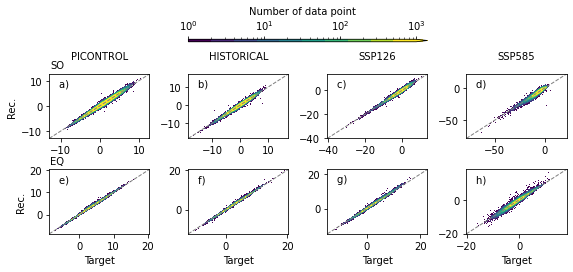

In [50]:
%%time
print(datetime.datetime.now())

select_processed_histogram = 'cfx'
print('Scatter plot reconstructed vs target focus: fig '+select_processed_histogram)

#-----------------
# Load data2plot
#-----------------

savedfile = dirout + 'scatter-rec-vs-target-focus.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)       

#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
nrow = len(latbox.keys())
ncol = len(simu_list)
fsize = (20*cm2in, 7*cm2in) # width height
fig, ax = plt.subplots(nrow, ncol, figsize=fsize,
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#-----------------
# CREATE CUSTOM CMAP
#-----------------

cmap = cm.get_cmap('viridis', 256)
newcolors = cmap(np.linspace(0, 1, 10))
cmap = ListedColormap(newcolors[:])
cmap.set_under(color='silver')
# cmap.set_over(color='silver')
cmap.set_bad(color='silver', alpha=0)


#---------------------
# PLOT 2D HISTOGRAMS
#---------------------

pcm = np.zeros_like(ax)

for ilatbox, (klatbox, vlatbox) in enumerate(latbox.items()): 
    
    for isimu, vsimu in enumerate(simu_list): 
               
       
        zax = ax[ilatbox, isimu]
        pcm[ilatbox, isimu] = zax.pcolormesh(data2plot[vsimu][klatbox][select_processed_histogram]['X'], 
                                             data2plot[vsimu][klatbox][select_processed_histogram]['Y'],
                                             data2plot[vsimu][klatbox][select_processed_histogram]['Z'], 
                                             norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap=cmap)
        ybounds = zax.yaxis.get_data_interval()
        xbounds = zax.xaxis.get_data_interval()
        bbb = [np.nanmin([ybounds[0], xbounds[0]]), np.nanmax([ybounds[1], xbounds[1]])]
        zax.plot(bbb, bbb, lw=1, c='gray', ls='--')
        
        
    #
#

fig.tight_layout()

#---------------------
# Add numbering to titles of subplots
#---------------------

for irow, axrow in enumerate(ax): 
    for zax in axrow: 
        zwtitle = subnum.pop() + ') '
        zax.annotate(zwtitle, (0.1, 0.8),xycoords='axes fraction')

    #
#

#---------------------
# Add text on the left: model names
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', weight='normal', ha='right', va='bottom')
for ilatbox, (klatbox, vlatbox) in enumerate(latbox.items()): 
    zw1 = ax[ilatbox, 0].get_position()
    ny0 = zw1.y1 + .05*zw1.height
    nx0 = zw1.x0 + .15*zw1.width
    fig.text(nx0, ny0, klatbox.upper(), **kwtxt)
#

#---------------------
# Add text on the top: simu names
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', weight='normal', ha='center', va='bottom')
for isimu, vsimu in enumerate(simu_list): 
    zw1 = ax[0, isimu].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .2*zw1.height
    fig.text(nx0, ny0, vsimu.upper(), **kwtxt)
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[0, 1].get_position()
zw2 = ax[0, 2].get_position()
nx0 = zw1.x0
ny0 = zw1.y1 + .5*zw1.height
nw  = zw2.x1 - nx0
nh  = 0.03*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm[0, 0], cax=cax, orientation='horizontal', \
                    ticklocation='top', extend='max')
cbar.set_label(r'Number of data point')

#---------------------
# Add x and ylabel
#---------------------

for iax, zax in enumerate(ax[:, 0]): zax.set_ylabel('Rec.')
for iax, zax in enumerate(ax[-1, :]): zax.set_xlabel('Target')

#---------------------
# Save figure
#---------------------

fignam = 'scatter-rec-vs-target-focus-'+select_processed_histogram+'.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# ca. 1m

# Maps other scores

## Input

In [6]:
%%time
print(datetime.datetime.now())
print('Maps other scores: input')

model_list = ['ACCESS-ESM1-5', 'CESM2', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR', 'NorESM2-LM']
# vmodel = 'NorESM2-LM'
simu_list  = ['picontrol', 'historical', 'ssp126', 'ssp585']
# vsimu = 'historical'
#grid_list  = ['90x45', '180x90']
grid  = '360x180'

###############
###############
###############
zfact = 1e6*3600*24 # kmol/m2/s -> mmol/m2/d
###############
###############
###############

2023-07-27 12:29:22.702763
Maps other scores: input
CPU times: user 59 µs, sys: 0 ns, total: 59 µs
Wall time: 62.9 µs


## Prepare and save data2plot

In [ ]:
%%time
print(datetime.datetime.now())
print('Maps other scores: prepare and save data2plot')

data2plot = {}

for imodel, vmodel in enumerate(model_list): 
   
    data2plot[vmodel] = {}

    for isimu, vsimu in enumerate(simu_list): 
        
        data2plot[vmodel][vsimu] = {}
        
        #_______________
        # Load datas
        savedfile = dirshared + 'cfx-true-pred-std-'+vmodel+'-'+vsimu+'-'+grid+'.pckl'
        with open(savedfile, 'rb') as f1: zwdata = pickle.load(f1)
        print("File loaded: "+savedfile)            

        cfxtrue = zwdata['cfxtrue'].T * zfact
        cfxpred = zwdata['cfxpred'].T * zfact        
        lon = zwdata['lon'].T
        lat = zwdata['lat'].T
        
        #_______________
        # loop on grid point
        zwpearson = np.zeros_like(cfxtrue[0])
        zwpvalue = np.zeros_like(cfxtrue[0])
        zwrmse = np.zeros_like(cfxtrue[0])
        zwmae = np.zeros_like(cfxtrue[0])
        zwstdtrue = np.zeros_like(cfxtrue[0])
        nt, ny, nx = cfxtrue.shape
        t = np.linspace(0, nt - 1, num=nt)
        for jjj in np.arange(ny): 
            for iii in np.arange(nx): 
                if not np.isnan(cfxtrue[0, jjj, iii]): 
                    
                    #_______________
                    # detrend and deseasonalized      
                    zwtrdtrue = p_smooth_spline(t, cfxtrue[:, jjj, iii])
                    zwdtdstrue, zwtrdseastrue, zwseastrue = dtrd_dseas(cfxtrue[:, jjj, iii], zwtrdtrue)
                    zwdtdspred = cfxpred[:, jjj, iii] - zwtrdseastrue
                    
                    #_______________
                    # compute scores
                    zwpearson[jjj, iii], zwpvalue[jjj, iii] = pearsonr(zwdtdstrue, zwdtdspred)
                    zwrmse[jjj, iii]    = np.sqrt(mean_squared_error(zwdtdstrue, zwdtdspred))
                    zwmae[jjj, iii]     = mean_absolute_error(zwdtdstrue, zwdtdspred)
                    zwstdtrue[jjj, iii] = np.std(zwdtdstrue)
                    
                else : 
                    zwpearson[jjj, iii] = np.nan
                    zwpvalue[jjj, iii]  = np.nan
                    zwrmse[jjj, iii]    = np.nan
                    zwmae[jjj, iii]     = np.nan
                    zwstdtrue[jjj, iii] = np.nan

                #
            #
        #
        
        #_______________
        data2plot[vmodel][vsimu]['pearson'] = {'X':lon, 'Y':lat, 'Z':zwpearson}
        data2plot[vmodel][vsimu]['pvalue']  = {'X':lon, 'Y':lat, 'Z':zwpvalue}
        data2plot[vmodel][vsimu]['rmse']    = {'X':lon, 'Y':lat, 'Z':zwrmse}
        data2plot[vmodel][vsimu]['mae']     = {'X':lon, 'Y':lat, 'Z':zwrmse}
        data2plot[vmodel][vsimu]['std']     = {'X':lon, 'Y':lat, 'Z':zwstdtrue}

    #
#

savedfile = dirout + 'maps-other-scores.pckl'
# savedfile = dirout + 'fi-no-std-' + vmodel+'-'+vsimu+'.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("File saved: "+savedfile)        


2023-07-27 12:29:24.739907
Maps other scores: prepare and save data2plot
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-ACCESS-ESM1-5-picontrol-360x180.pckl


## Fig

### Pearson

2023-07-27 16:29:02.040187
Maps other scores: fig, pearson
File loaded: dimred-230621-figure-article-review1-v0/maps-other-scores.pckl
Figure saved: maps-other-score-pearson.png
CPU times: user 1min 36s, sys: 805 ms, total: 1min 37s
Wall time: 1min 37s


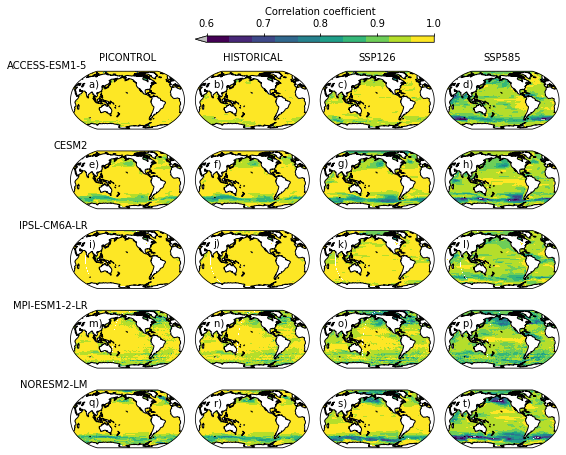

In [8]:
%%time
print(datetime.datetime.now())

scorename='pearson'
cbarname='Correlation coefficient'
print('Maps other scores: fig, '+scorename)

#-----------------
# Load data2plot
#-----------------

savedfile = dirout + 'maps-other-scores.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)       


#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
nrow = len(model_list)
ncol = len(simu_list)
fsize = (18*cm2in, 16*cm2in) # width height
ccrsproj = ccrs.Robinson(central_longitude=-155)
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, 
                       subplot_kw=dict(projection=ccrsproj),
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#-----------------
# CREATE CUSTOM CMAP
#-----------------

cmap = cm.get_cmap('viridis', 256)
newcolors = cmap(np.linspace(0, 1, 10))
cmap = ListedColormap(newcolors[:])
cmap.set_under(color='silver')
cmap.set_over(color='silver')
cmap.set_bad(color='silver', alpha=0)

#-----------------
# KEYWORDS DICT
#-----------------

kwmap = {'vmin':0.6, 'vmax':1, 'cmap':cmap, \
         'transform':ccrs.PlateCarree() }

#---------------------
# Plot score maps
#---------------------

pcm = np.zeros_like(ax)

for imodel, vmodel in enumerate(model_list): 
    for isimu, vsimu in enumerate(simu_list): 
        zax = ax[imodel, isimu]
        X = data2plot[vmodel][vsimu][scorename]['X']
        Y = data2plot[vmodel][vsimu][scorename]['Y']
        Z = data2plot[vmodel][vsimu][scorename]['Z']
        pcm = zax.pcolormesh(X, Y, Z, **kwmap)    
        #zax.set_title(subnum.pop()+') '+ model+'\n'+simu_name[simu].upper())
        zax.coastlines()
        # gl = zax.gridlines(crs=ccrs.PlateCarree(), linewidth=1)
    #
#
fig.tight_layout()

#---------------------
# Repositionning axes
#---------------------

for irow, axrow in enumerate(ax[1:]): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        ny0 = zw1.y0 + (irow+1)*0.1*zw1.height
        zax.set_position([zw1.x0, ny0, zw1.width, zw1.height])
    #
#

#---------------------
# Add numbering to subplots
#---------------------

for irow, axrow in enumerate(ax): 
    for zax in axrow: 
        zwtitle = subnum.pop() + ') '
        zax.annotate(zwtitle, (0.16, 0.72),xycoords='axes fraction')

    #
#

#---------------------
# Add text on the left: model names
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', weight='normal', ha='right', va='bottom')
for imodel, vmodel in enumerate(model_list): 
    zw1 = ax[imodel, 0].get_position()
    ny0 = zw1.y1  
    nx0 = zw1.x0 + 0.15*zw1.width
    fig.text(nx0, ny0, vmodel.upper(), **kwtxt)
#

#---------------------
# Add text on the top: simu names
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', weight='normal', ha='center', va='bottom')
for isimu, vsimu in enumerate(simu_list): 
    zw1 = ax[0, isimu].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .15*zw1.height
    fig.text(nx0, ny0, vsimu.upper(), **kwtxt)
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[0, 1].get_position()
zw2 = ax[0, 2].get_position()
nx0 = zw1.x0
ny0 = zw1.y1 + .5*zw1.height
nw  = zw2.x1 - nx0
nh  = 0.03*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal', \
                    ticklocation='top', extend='min')
cbar.set_label(cbarname)

#---------------------
# Save figure
#---------------------

fignam = 'maps-other-score-'+scorename+'.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# 1m40s

### pvalue

2023-07-27 16:30:41.084945
Maps other scores: fig, pvalue
File loaded: dimred-230621-figure-article-review1-v0/maps-other-scores.pckl
Figure saved: maps-other-score-pvalue.png
CPU times: user 1min 36s, sys: 893 ms, total: 1min 37s
Wall time: 1min 36s


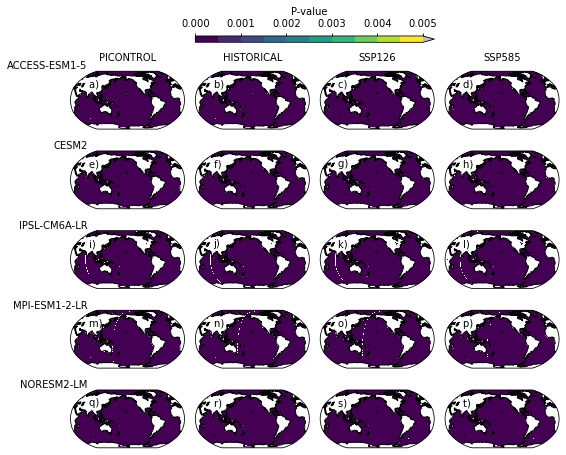

In [9]:
%%time
print(datetime.datetime.now())

scorename='pvalue'
cbarname='P-value'
print('Maps other scores: fig, '+scorename)

#-----------------
# Load data2plot
#-----------------

savedfile = dirout + 'maps-other-scores.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)       


#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
nrow = len(model_list)
ncol = len(simu_list)
fsize = (18*cm2in, 16*cm2in) # width height
ccrsproj = ccrs.Robinson(central_longitude=-155)
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, 
                       subplot_kw=dict(projection=ccrsproj),
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#-----------------
# CREATE CUSTOM CMAP
#-----------------

cmap = cm.get_cmap('viridis', 256)
newcolors = cmap(np.linspace(0, 1, 10))
cmap = ListedColormap(newcolors[:])
cmap.set_under(color='silver')
cmap.set_over(color='silver')
cmap.set_bad(color='silver', alpha=0)

#-----------------
# KEYWORDS DICT
#-----------------

kwmap = {'vmin':0, 'vmax':.005, 'cmap':cmap, \
         'transform':ccrs.PlateCarree() }

#---------------------
# Plot score maps
#---------------------

pcm = np.zeros_like(ax)

for imodel, vmodel in enumerate(model_list): 
    for isimu, vsimu in enumerate(simu_list): 
        zax = ax[imodel, isimu]
        X = data2plot[vmodel][vsimu][scorename]['X']
        Y = data2plot[vmodel][vsimu][scorename]['Y']
        Z = data2plot[vmodel][vsimu][scorename]['Z']
        pcm = zax.pcolormesh(X, Y, Z, **kwmap)    
        #zax.set_title(subnum.pop()+') '+ model+'\n'+simu_name[simu].upper())
        zax.coastlines()
        # gl = zax.gridlines(crs=ccrs.PlateCarree(), linewidth=1)
    #
#
fig.tight_layout()

#---------------------
# Repositionning axes
#---------------------

for irow, axrow in enumerate(ax[1:]): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        ny0 = zw1.y0 + (irow+1)*0.1*zw1.height
        zax.set_position([zw1.x0, ny0, zw1.width, zw1.height])
    #
#

#---------------------
# Add numbering to subplots
#---------------------

for irow, axrow in enumerate(ax): 
    for zax in axrow: 
        zwtitle = subnum.pop() + ') '
        zax.annotate(zwtitle, (0.16, 0.72),xycoords='axes fraction')

    #
#

#---------------------
# Add text on the left: model names
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', weight='normal', ha='right', va='bottom')
for imodel, vmodel in enumerate(model_list): 
    zw1 = ax[imodel, 0].get_position()
    ny0 = zw1.y1  
    nx0 = zw1.x0 + 0.15*zw1.width
    fig.text(nx0, ny0, vmodel.upper(), **kwtxt)
#

#---------------------
# Add text on the top: simu names
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', weight='normal', ha='center', va='bottom')
for isimu, vsimu in enumerate(simu_list): 
    zw1 = ax[0, isimu].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .15*zw1.height
    fig.text(nx0, ny0, vsimu.upper(), **kwtxt)
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[0, 1].get_position()
zw2 = ax[0, 2].get_position()
nx0 = zw1.x0
ny0 = zw1.y1 + .5*zw1.height
nw  = zw2.x1 - nx0
nh  = 0.03*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal', \
                    ticklocation='top', extend='max')
cbar.set_label(cbarname)

#---------------------
# Save figure
#---------------------

fignam = 'maps-other-score-'+scorename+'.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# 1m40s

### RMSE

2023-07-27 16:32:19.863942
Maps other scores: fig, rmse
File loaded: dimred-230621-figure-article-review1-v0/maps-other-scores.pckl
Figure saved: maps-other-score-rmse.png
CPU times: user 1min 36s, sys: 1.11 s, total: 1min 38s
Wall time: 1min 37s


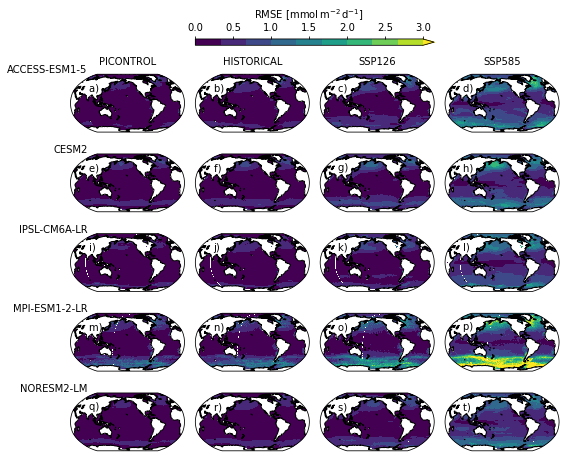

In [10]:
%%time
print(datetime.datetime.now())

scorename='rmse'
cbarname='RMSE [mmol$\,$m$^{-2}\,$d$^{-1}$]'
print('Maps other scores: fig, '+scorename)

#-----------------
# Load data2plot
#-----------------

savedfile = dirout + 'maps-other-scores.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)       


#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
nrow = len(model_list)
ncol = len(simu_list)
fsize = (18*cm2in, 16*cm2in) # width height
ccrsproj = ccrs.Robinson(central_longitude=-155)
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, 
                       subplot_kw=dict(projection=ccrsproj),
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#-----------------
# CREATE CUSTOM CMAP
#-----------------

cmap = cm.get_cmap('viridis', 256)
newcolors = cmap(np.linspace(0, 1, 10))
cmap = ListedColormap(newcolors[:-1])
cmap.set_under(color='silver')
cmap.set_over(color=newcolors[-1])
cmap.set_bad(color='silver', alpha=0)

#-----------------
# KEYWORDS DICT
#-----------------

kwmap = {'vmin':0, 'vmax':3, 'cmap':cmap, \
         'transform':ccrs.PlateCarree() }

#---------------------
# Plot score maps
#---------------------

pcm = np.zeros_like(ax)

for imodel, vmodel in enumerate(model_list): 
    for isimu, vsimu in enumerate(simu_list): 
        zax = ax[imodel, isimu]
        X = data2plot[vmodel][vsimu][scorename]['X']
        Y = data2plot[vmodel][vsimu][scorename]['Y']
        Z = data2plot[vmodel][vsimu][scorename]['Z']
        pcm = zax.pcolormesh(X, Y, Z, **kwmap)    
        #zax.set_title(subnum.pop()+') '+ model+'\n'+simu_name[simu].upper())
        zax.coastlines()
        # gl = zax.gridlines(crs=ccrs.PlateCarree(), linewidth=1)
    #
#
fig.tight_layout()

#---------------------
# Repositionning axes
#---------------------

for irow, axrow in enumerate(ax[1:]): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        ny0 = zw1.y0 + (irow+1)*0.1*zw1.height
        zax.set_position([zw1.x0, ny0, zw1.width, zw1.height])
    #
#

#---------------------
# Add numbering to subplots
#---------------------

for irow, axrow in enumerate(ax): 
    for zax in axrow: 
        zwtitle = subnum.pop() + ') '
        zax.annotate(zwtitle, (0.16, 0.72),xycoords='axes fraction')

    #
#

#---------------------
# Add text on the left: model names
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', weight='normal', ha='right', va='bottom')
for imodel, vmodel in enumerate(model_list): 
    zw1 = ax[imodel, 0].get_position()
    ny0 = zw1.y1  
    nx0 = zw1.x0 + 0.15*zw1.width
    fig.text(nx0, ny0, vmodel.upper(), **kwtxt)
#

#---------------------
# Add text on the top: simu names
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', weight='normal', ha='center', va='bottom')
for isimu, vsimu in enumerate(simu_list): 
    zw1 = ax[0, isimu].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .15*zw1.height
    fig.text(nx0, ny0, vsimu.upper(), **kwtxt)
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[0, 1].get_position()
zw2 = ax[0, 2].get_position()
nx0 = zw1.x0
ny0 = zw1.y1 + .5*zw1.height
nw  = zw2.x1 - nx0
nh  = 0.03*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal', \
                    ticklocation='top', extend='max')
cbar.set_label(cbarname)

#---------------------
# Save figure
#---------------------

fignam = 'maps-other-score-'+scorename+'.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# 1m40s

### MAE

2023-07-27 16:33:59.282008
Maps other scores: fig, mae
File loaded: dimred-230621-figure-article-review1-v0/maps-other-scores.pckl
Figure saved: maps-other-score-mae.png
CPU times: user 1min 36s, sys: 906 ms, total: 1min 37s
Wall time: 1min 37s


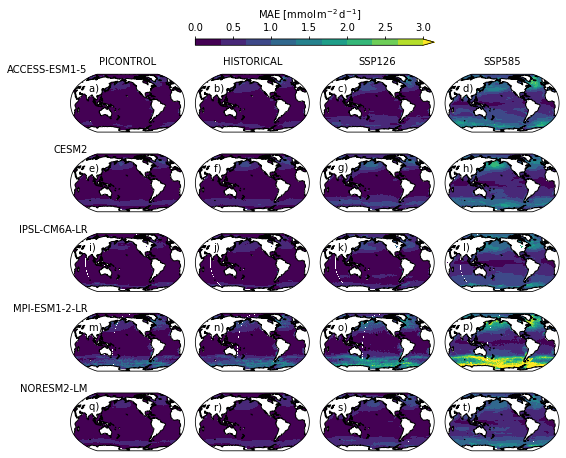

In [11]:
%%time
print(datetime.datetime.now())

scorename='mae'
cbarname='MAE [mmol$\,$m$^{-2}\,$d$^{-1}$]'
print('Maps other scores: fig, '+scorename)

#-----------------
# Load data2plot
#-----------------

savedfile = dirout + 'maps-other-scores.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)       


#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
nrow = len(model_list)
ncol = len(simu_list)
fsize = (18*cm2in, 16*cm2in) # width height
ccrsproj = ccrs.Robinson(central_longitude=-155)
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, 
                       subplot_kw=dict(projection=ccrsproj),
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#-----------------
# CREATE CUSTOM CMAP
#-----------------

cmap = cm.get_cmap('viridis', 256)
newcolors = cmap(np.linspace(0, 1, 10))
cmap = ListedColormap(newcolors[:-1])
cmap.set_under(color='silver')
cmap.set_over(color=newcolors[-1])
cmap.set_bad(color='silver', alpha=0)

#-----------------
# KEYWORDS DICT
#-----------------

kwmap = {'vmin':0, 'vmax':3, 'cmap':cmap, \
         'transform':ccrs.PlateCarree() }

#---------------------
# Plot score maps
#---------------------

pcm = np.zeros_like(ax)

for imodel, vmodel in enumerate(model_list): 
    for isimu, vsimu in enumerate(simu_list): 
        zax = ax[imodel, isimu]
        X = data2plot[vmodel][vsimu][scorename]['X']
        Y = data2plot[vmodel][vsimu][scorename]['Y']
        Z = data2plot[vmodel][vsimu][scorename]['Z']
        pcm = zax.pcolormesh(X, Y, Z, **kwmap)    
        #zax.set_title(subnum.pop()+') '+ model+'\n'+simu_name[simu].upper())
        zax.coastlines()
        # gl = zax.gridlines(crs=ccrs.PlateCarree(), linewidth=1)
    #
#
fig.tight_layout()

#---------------------
# Repositionning axes
#---------------------

for irow, axrow in enumerate(ax[1:]): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        ny0 = zw1.y0 + (irow+1)*0.1*zw1.height
        zax.set_position([zw1.x0, ny0, zw1.width, zw1.height])
    #
#

#---------------------
# Add numbering to subplots
#---------------------

for irow, axrow in enumerate(ax): 
    for zax in axrow: 
        zwtitle = subnum.pop() + ') '
        zax.annotate(zwtitle, (0.16, 0.72),xycoords='axes fraction')

    #
#

#---------------------
# Add text on the left: model names
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', weight='normal', ha='right', va='bottom')
for imodel, vmodel in enumerate(model_list): 
    zw1 = ax[imodel, 0].get_position()
    ny0 = zw1.y1  
    nx0 = zw1.x0 + 0.15*zw1.width
    fig.text(nx0, ny0, vmodel.upper(), **kwtxt)
#

#---------------------
# Add text on the top: simu names
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', weight='normal', ha='center', va='bottom')
for isimu, vsimu in enumerate(simu_list): 
    zw1 = ax[0, isimu].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .15*zw1.height
    fig.text(nx0, ny0, vsimu.upper(), **kwtxt)
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[0, 1].get_position()
zw2 = ax[0, 2].get_position()
nx0 = zw1.x0
ny0 = zw1.y1 + .5*zw1.height
nw  = zw2.x1 - nx0
nh  = 0.03*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal', \
                    ticklocation='top', extend='max')
cbar.set_label(cbarname)

#---------------------
# Save figure
#---------------------

fignam = 'maps-other-score-'+scorename+'.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# 1m40s

### stdtrue

2023-07-27 16:35:38.645882
Maps other scores: fig, std
File loaded: dimred-230621-figure-article-review1-v0/maps-other-scores.pckl
Figure saved: maps-other-score-std.png
CPU times: user 1min 36s, sys: 897 ms, total: 1min 37s
Wall time: 1min 37s


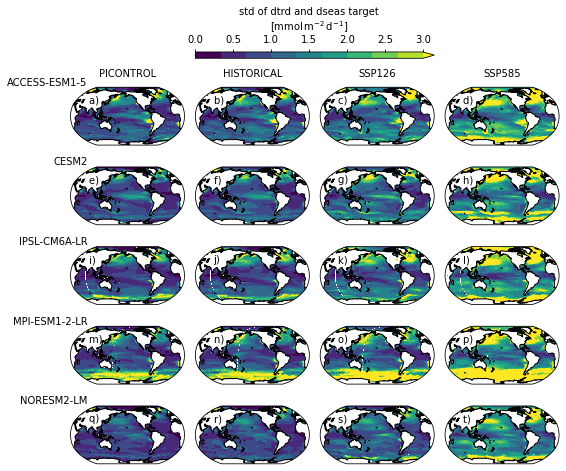

In [12]:
%%time
print(datetime.datetime.now())

scorename='std'
cbarname='std of dtrd and dseas target\n[mmol$\,$m$^{-2}\,$d$^{-1}$]'
print('Maps other scores: fig, '+scorename)

#-----------------
# Load data2plot
#-----------------

savedfile = dirout + 'maps-other-scores.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)       


#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
nrow = len(model_list)
ncol = len(simu_list)
fsize = (18*cm2in, 16*cm2in) # width height
ccrsproj = ccrs.Robinson(central_longitude=-155)
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, 
                       subplot_kw=dict(projection=ccrsproj),
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#-----------------
# CREATE CUSTOM CMAP
#-----------------

cmap = cm.get_cmap('viridis', 256)
newcolors = cmap(np.linspace(0, 1, 10))
cmap = ListedColormap(newcolors[:-1])
cmap.set_under(color='silver')
cmap.set_over(color=newcolors[-1])
cmap.set_bad(color='silver', alpha=0)

#-----------------
# KEYWORDS DICT
#-----------------

kwmap = {'vmin':0, 'vmax':3, 'cmap':cmap, \
         'transform':ccrs.PlateCarree() }

#---------------------
# Plot score maps
#---------------------

pcm = np.zeros_like(ax)

for imodel, vmodel in enumerate(model_list): 
    for isimu, vsimu in enumerate(simu_list): 
        zax = ax[imodel, isimu]
        X = data2plot[vmodel][vsimu][scorename]['X']
        Y = data2plot[vmodel][vsimu][scorename]['Y']
        Z = data2plot[vmodel][vsimu][scorename]['Z']
        pcm = zax.pcolormesh(X, Y, Z, **kwmap)    
        #zax.set_title(subnum.pop()+') '+ model+'\n'+simu_name[simu].upper())
        zax.coastlines()
        # gl = zax.gridlines(crs=ccrs.PlateCarree(), linewidth=1)
    #
#
fig.tight_layout()

#---------------------
# Repositionning axes
#---------------------

for irow, axrow in enumerate(ax[1:]): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        ny0 = zw1.y0 + (irow+1)*0.1*zw1.height
        zax.set_position([zw1.x0, ny0, zw1.width, zw1.height])
    #
#

#---------------------
# Add numbering to subplots
#---------------------

for irow, axrow in enumerate(ax): 
    for zax in axrow: 
        zwtitle = subnum.pop() + ') '
        zax.annotate(zwtitle, (0.16, 0.72),xycoords='axes fraction')

    #
#

#---------------------
# Add text on the left: model names
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', weight='normal', ha='right', va='bottom')
for imodel, vmodel in enumerate(model_list): 
    zw1 = ax[imodel, 0].get_position()
    ny0 = zw1.y1  
    nx0 = zw1.x0 + 0.15*zw1.width
    fig.text(nx0, ny0, vmodel.upper(), **kwtxt)
#

#---------------------
# Add text on the top: simu names
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', weight='normal', ha='center', va='bottom')
for isimu, vsimu in enumerate(simu_list): 
    zw1 = ax[0, isimu].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .15*zw1.height
    fig.text(nx0, ny0, vsimu.upper(), **kwtxt)
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[0, 1].get_position()
zw2 = ax[0, 2].get_position()
nx0 = zw1.x0
ny0 = zw1.y1 + .5*zw1.height
nw  = zw2.x1 - nx0
nh  = 0.03*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal', \
                    ticklocation='top', extend='max')
cbar.set_label(cbarname)

#---------------------
# Save figure
#---------------------

fignam = 'maps-other-score-'+scorename+'.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# 1m40s